In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-04-17 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

Data Source: [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19), the data behind the dashboard: [Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

It seems that there are currently [data-changes](https://github.com/CSSEGISandData/COVID-19/commit/0cea9b2179306618bd7917798819ebf6608d67de#comments) in progress that cause issues. This is mostly an issue for the US data, so that I comment it out. The US data as used in this notebook **is currently wrong**.

In [5]:
covid19.time_series_19_covid_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19


In [6]:
covid19.time_series_19_covid_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,5,5,10,10,10,15,18,18,29,32,32,32,32,32,40,43,54
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,10,17,17,31,31,33,44,52,67,76,89,99,104,116,131,154,165,182,197,217,232,248,251,277
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32,65,65,24,65,29,29,31,31,37,46,61,61,62,90,90,90,113,237,347,405,460,591,601,691,708,783
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,10,10,10,10,16,21,26,31,39,52,58,71,71,128,128,128,169,169
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2,4,4,4,5,5,5


In [7]:
list(covid19.augment_time_series_from_daily_snapshots_date_range)

[]

In [8]:
# ldf = covid19.augment_time_series_from_daily_snapshots(covid19.augment_time_series_from_daily_snapshots_date_range)
# ldf

In [9]:
# ldf = covid19.augment_time_series_from_daily_snapshots(covid19.augment_time_series_from_daily_snapshots_date_range)[0][['Province/State', 'Country/Region', '3/15/20']]
# # # ldf[ldf['3/14/20'] < 0]
# ldf[ldf['Country/Region'] == 'Spain']

In [10]:
# ldf_confirmed, ldf_recovered, ldf_death, columns, selector = covid19.get_cases_by_region()

In [11]:
df = covid19.get_cases_by_region()
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-12,124242,60260,2834,2918,2070,145
2020-04-13,126615,62925,2993,2373,2665,159
2020-04-14,128474,67056,3217,1859,4131,224
2020-04-15,131411,71995,3556,2937,4939,339
2020-04-16,134404,76881,3837,2993,4886,281


In [12]:
df = covid19.get_cases_by_region(region='China')
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-12,83134,77956,3343,120,79,0
2020-04-13,83213,78039,3345,79,83,2
2020-04-14,83306,78200,3345,93,161,0
2020-04-15,83356,78311,3346,50,111,1
2020-04-16,83403,78401,3346,47,90,0


In [13]:
# df = covid19.get_cases_by_region(region='Switzerland')
# df

In [14]:
# df = covid19.get_cases_by_region(region='US')
# df

* [BAR CHART ANNOTATIONS WITH PANDAS AND MATPLOTLIB](https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html)

In [15]:
cbr_germany = covid19.CasesByRegion('Germany')
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-12,124242,60260,2834,2918,2070,145
2020-04-13,126615,62925,2993,2373,2665,159
2020-04-14,128474,67056,3217,1859,4131,224
2020-04-15,131411,71995,3556,2937,4939,339
2020-04-16,134404,76881,3837,2993,4886,281


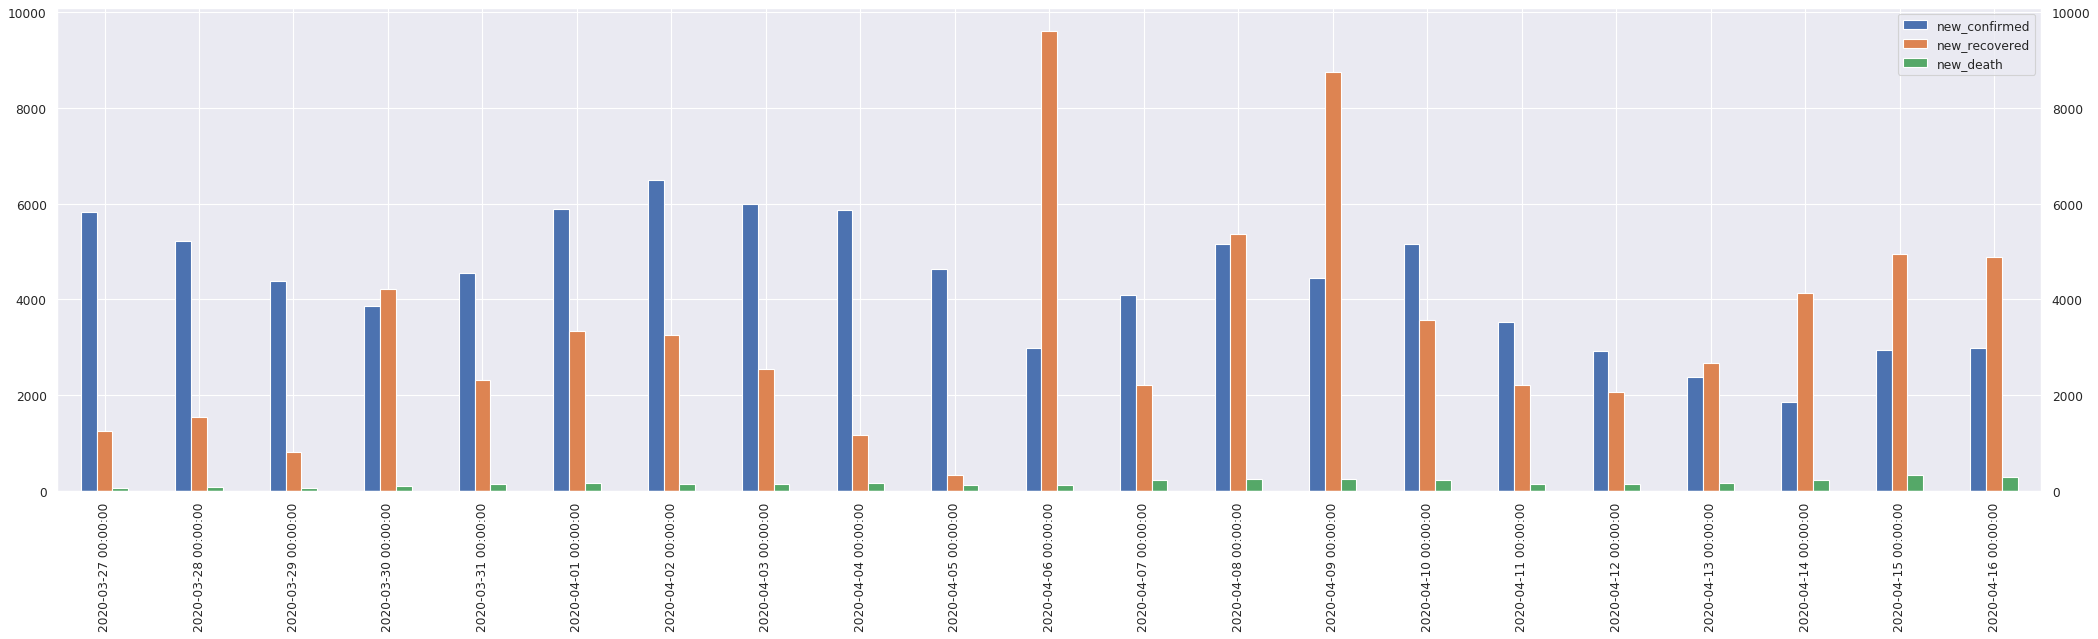

In [16]:
cbr_germany.plot_daily_stats()

135.0 184.0


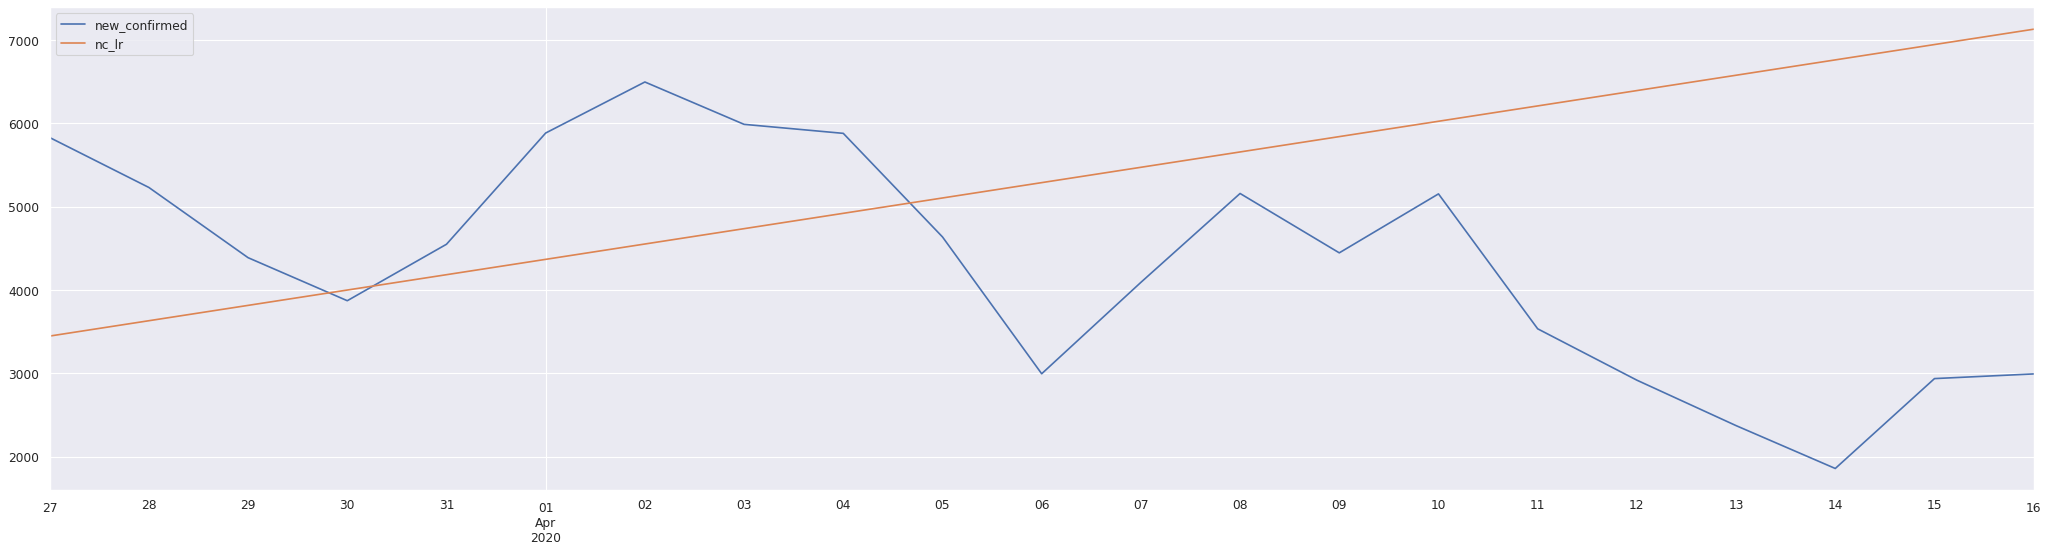

In [17]:
date_range = pd.date_range(pd.to_datetime('2020-03-09'),pd.to_datetime('2020-03-16'))
cbr_germany_new_confirmed_df = cbr_germany.df.loc[date_range,['new_confirmed']]
x = np.arange(len(cbr_germany_new_confirmed_df) * 1.0)

regressor = sklearn.linear_model.LinearRegression()  
regressor.fit(x.reshape(-1, 1), cbr_germany_new_confirmed_df.new_confirmed.values.reshape(-1, 1) * 1.0)

last_day = cbr_germany.df.index[-1]
ldr = pd.date_range(pd.to_datetime('2020-03-09'),pd.to_datetime(last_day))
x = np.arange(len(ldr) * 1.0)

y = regressor.intercept_[0] + regressor.coef_[0,0]*x
cbr_germany_new_confirmed_lr_df = pd.DataFrame(y.reshape(-1,1),index=ldr, columns=['nc_lr'])

ldf = pd.concat([cbr_germany.df, cbr_germany_new_confirmed_lr_df], axis=1)
ldf.loc[:] = ldf.values * 1.0
ldf = ldf.loc[last_day + datetime.timedelta(days=-20):,['new_confirmed', 'nc_lr']]
fig = plt.figure(figsize=(32, 8), dpi=80, facecolor='w', edgecolor='k')
ax  = plt.subplot(1, 1, 1)
ldf.plot(ax=ax)
print(regressor.intercept_[0].round(2), regressor.coef_[0,0].round(2))

[COVID-19-Pandemie#Deutschland](https://de.wikipedia.org/wiki/COVID-19-Pandemie#Deutschland):

> Am 22. März 2020 einigten sich Bund und Länder auf ein „umfassendes Kontaktverbot“, statt weitergehende Ausgangssperren zu beschließen.

| prediction date | predicted day for reaching 100 threshold | predicted max | growth rate  | steady state rate  |
| :--- | :--- | ---: | ---: | ---: |
| 2020-04-02 | 2020-04-21 |  92845 | 0.057 | - |
| 2020-04-03 | 2020-04-23 |  99774 | 0.054 | - |
| 2020-04-04 | 2020-04-25 | 107193 | 0.051 | - |
| 2020-04-05 | 2020-04-27 | 114511 | 0.049 | - |
| 2020-04-06 | 2020-04-29 | 119618 | 0.045 | - |
| 2020-04-07 | 2020-04-29 | 121354 | 0.039 | - |
| 2020-04-08 | 2020-04-30 | 123011 | 0.035 | - |
| 2020-04-09 | 2020-04-30 | 125833 | 0.031 | - |
| 2020-04-10 | - | - | 0.049 | 4820 |
| 2020-04-11 | - | - | 0.042 | 4739 |
| 2020-04-12 | - | - | 0.040 | 4570 |
| 2020-04-13 | - | - | 0.036 | 4300 |
| 2020-04-14 | - | - | 0.033 | 3927 |
| 2020-04-15 | - | - | 0.029 | 3451 |
| 2020-04-16 | - | - | 0.026 | 3086 |
| 2020-04-17 | - | - | 0.024 | 2845 |

sigmoid+linear 2020-05-25 00:00:00 [82219.43339894     0.19800519    -3.89271092 14368.25380685] 0.023754749048785273 2844.988837480022


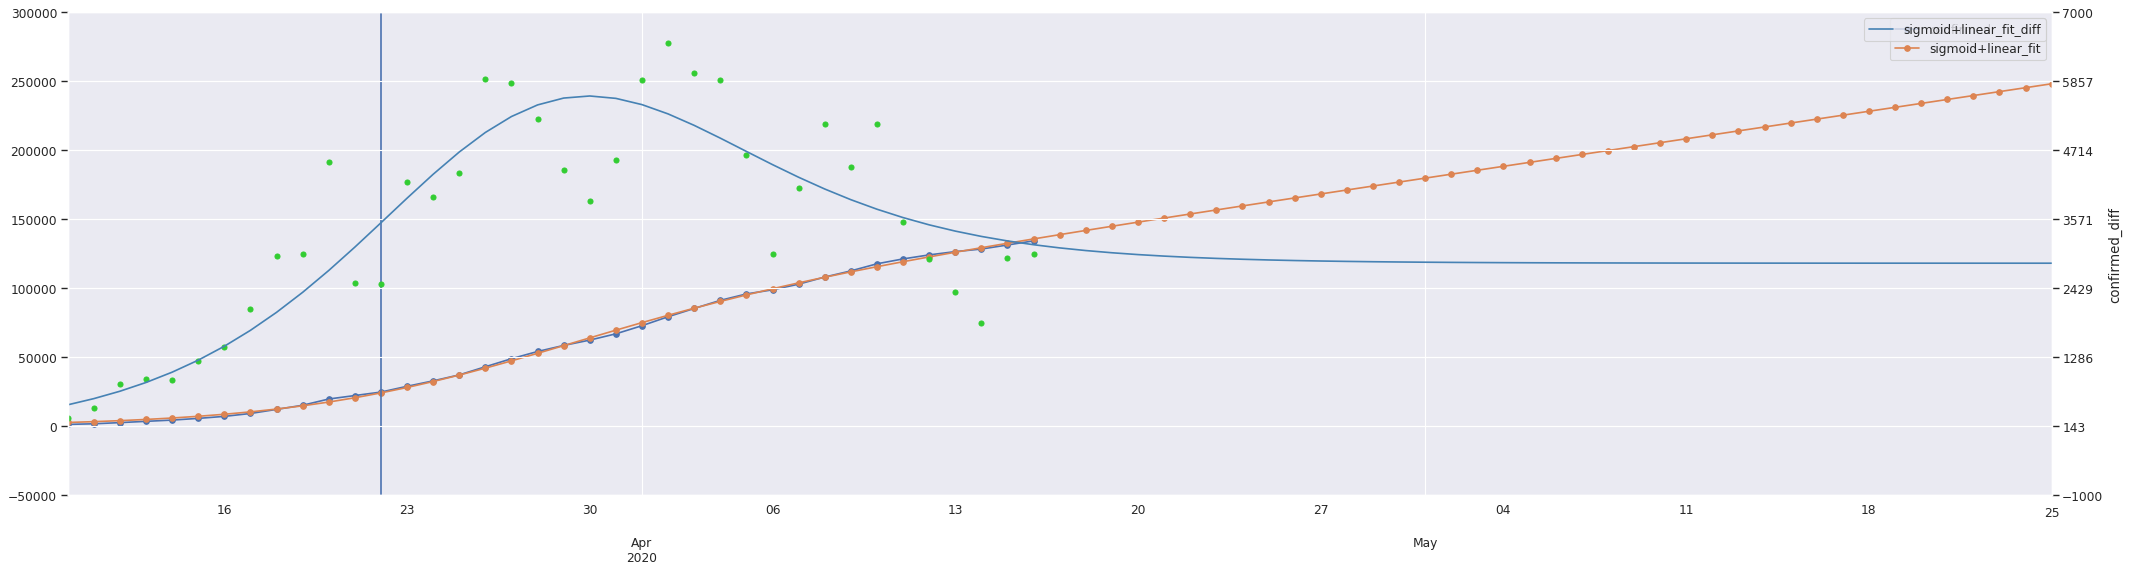

In [18]:
country_name, first_date, init_add, restriction_start_date = 'Germany', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(a2, e2, l));

In [19]:
ldf[[label + '_fit_diff']].apply(['max'])

,sigmoid+linear_fit_diff
max,5613.532923


In [20]:
lds = ldf['confirmed']
idx = lds.index.get_loc(lds.last_valid_index())
lds.iloc[idx] - lds.iloc[idx-1]

2993.0

sigmoid+linear 2020-05-21 00:00:00 [70629.43315749     1.48370961    -3.96584081 16035.7513348 ] 0.2998631420995981 23792.398420702382 0.03817625111154843 3398.9140601003405


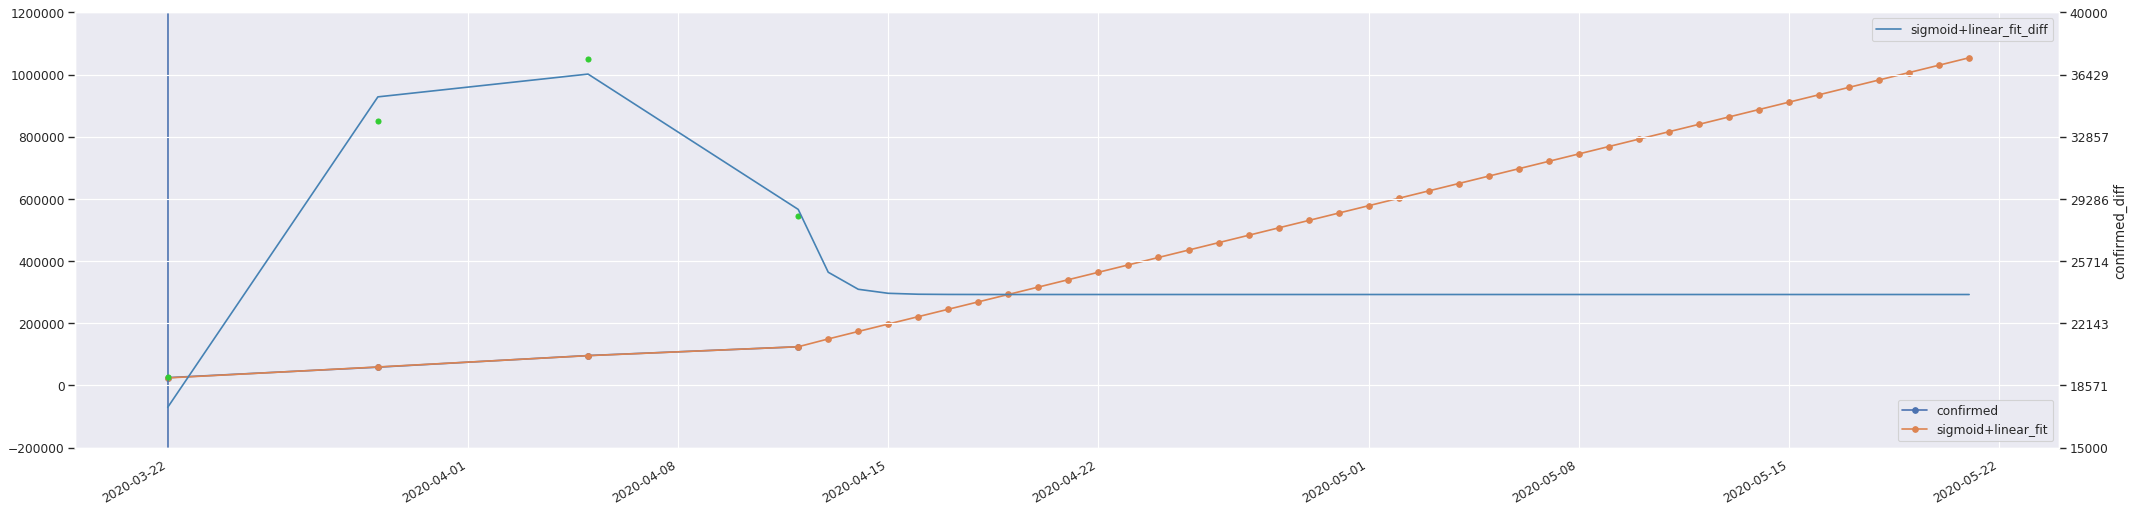

In [21]:
last_date_for_week_aggregation = cbr_germany.df.index[-1] + relativedelta.relativedelta(weekday=relativedelta.SU(-1))
ldf = cbr_germany.df[(cbr_germany.df.index >= first_date) & (cbr_germany.df.index <= last_date_for_week_aggregation)][['confirmed']]
in_df = ldf.resample('W').agg(pd.Series.max, skipna=False) #.sum(skipna=False) # 

ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add, in_df=in_df)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate, np.power(1.0 + lgrowthRate,1/7) - 1.0, steady_state_rate / 7)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(a2, e2, l));

In [22]:
# ldf.round(2)

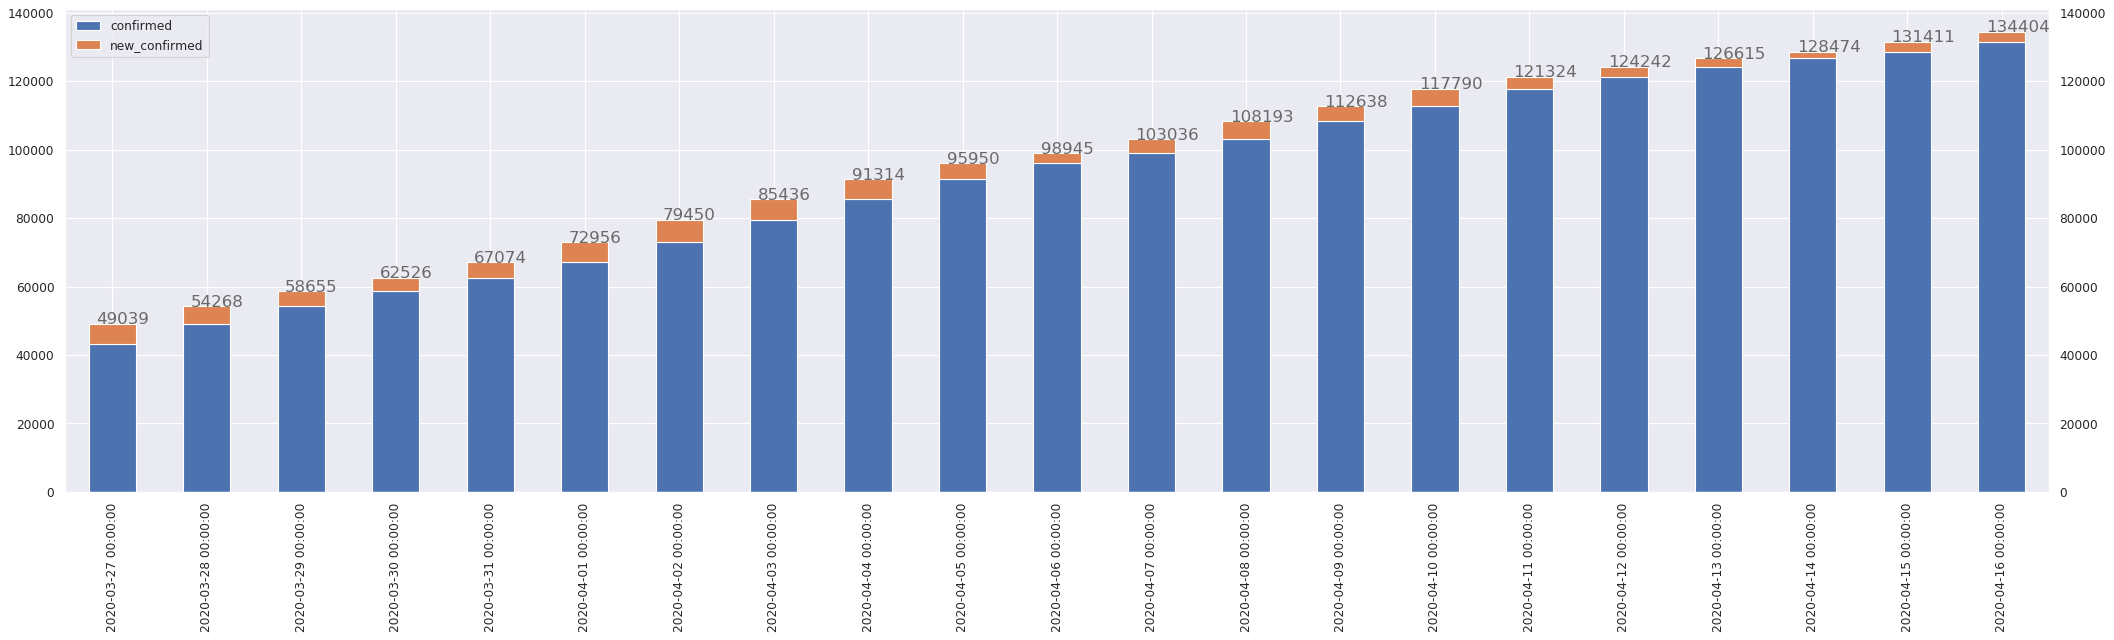

In [23]:
cbr_germany.plot_daily_stacked()

In [24]:
cbr_austria = covid19.CasesByRegion('Austria')
cbr_austria.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-12,14049,7343,368,106,739,31
2020-04-13,14140,7633,384,91,290,16
2020-04-14,14280,8098,393,140,465,9
2020-04-15,14370,8986,410,90,888,17
2020-04-16,14499,9704,431,129,718,21


[COVID-19-Pandemie#%C3%96sterreich](https://de.wikipedia.org/wiki/COVID-19-Pandemie#%C3%96sterreich)

> Nachdem Mitte März zuerst einzelne Gemeinden unter Quarantäne gestellt wurden, verlautbarte Bundeskanzler Sebastian Kurz am 15. März eine landesweite Ausgangsbeschränkung, verbunden mit einer Einschränkung der Versammlungsfreiheit auf bis zu fünf Personen.

`2020-03-15`

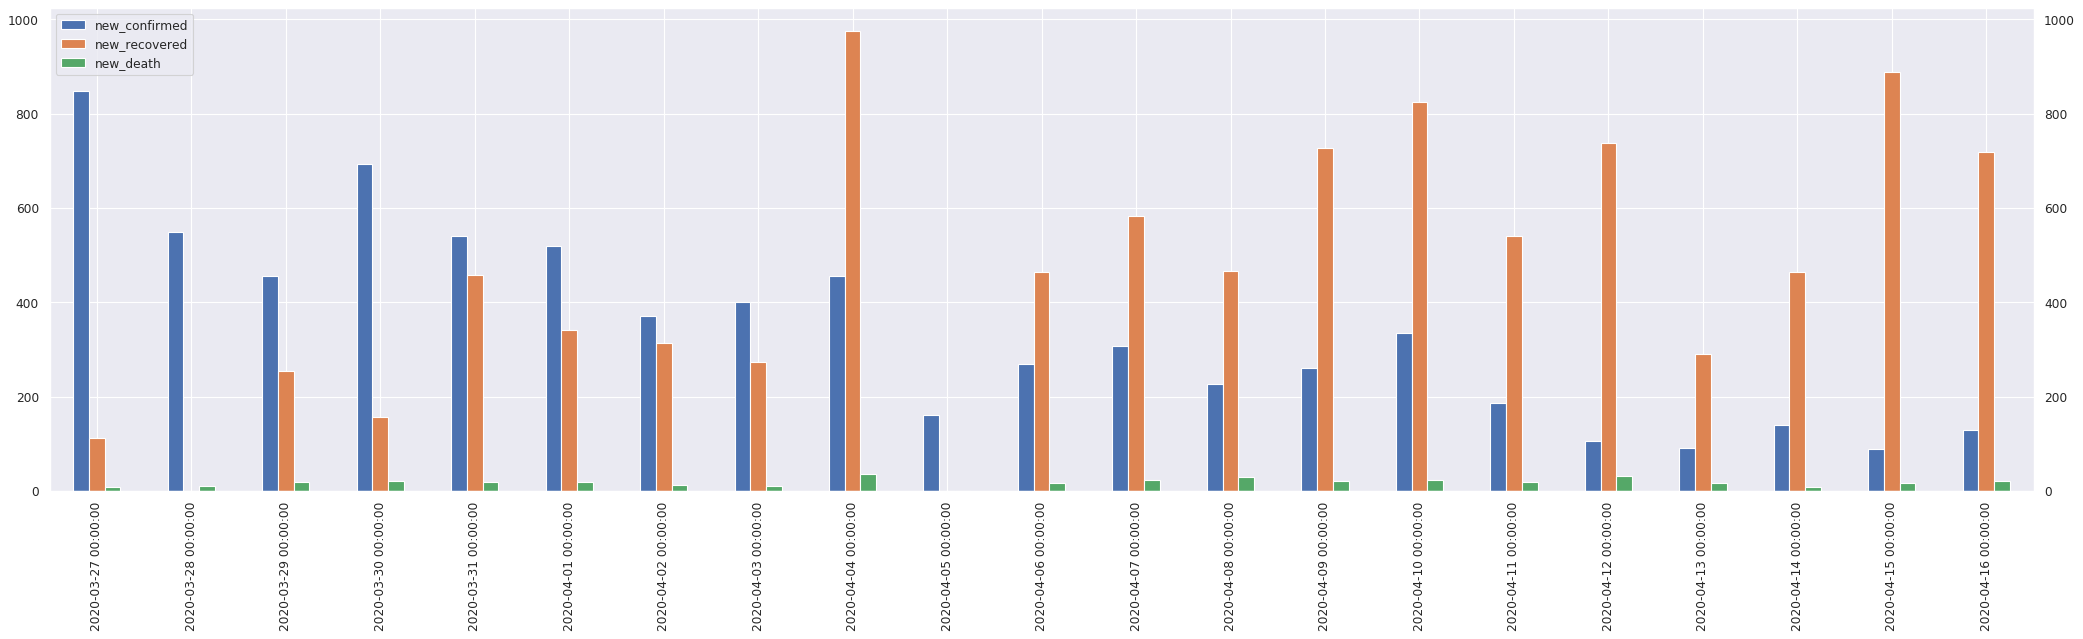

In [25]:
cbr_austria.plot_daily_stats()

| prediction date | predicted day for reaching 100 threshold | predicted max | growth rate | steady state rate  |
| :--- | :--- | ---: | ---: | ---: |
| 2020-04-02 | 2020-04-12 | 13859 | 0.042 | - |
| 2020-04-03 | 2020-04-12 | 13864 | 0.036 | - |
| 2020-04-04 | 2020-04-12 | 14082 | 0.030 | - |
| 2020-04-05 | 2020-04-12 | 13978 | 0.025 | - |
| 2020-04-06 | 2020-04-11 | 13947 | 0.020 | - |
| 2020-04-07 | 2020-04-12 | 14033 | 0.017 | - |
| 2020-04-08 | 2020-04-12 | 14121 | 0.014 | - |
| 2020-04-09 | 2020-04-12 | 14229 | 0.012 | - |
| 2020-04-10 | 2020-04-12 | 14350 | 0.010 | - |
| 2020-04-11 | 2020-04-13 | 14488 | 0.009 | - |
| 2020-04-12 | - | - | 0.012 | 106 |
| 2020-04-13 | - | - | 0.012 | 123 |
| 2020-04-14 | - | - | 0.011 | 126 |
| 2020-04-15 | - | - | 0.010 | 114 |
| 2020-04-15 | - | - | 0.009 | 107 |
| 2020-04-17 | - | - | 0.009 | 106 |

sigmoid+linear 2020-05-25 00:00:00 [12868.00979075     0.21082868    -2.86040553   503.52924926] 0.008746126777147145 106.15840897106166


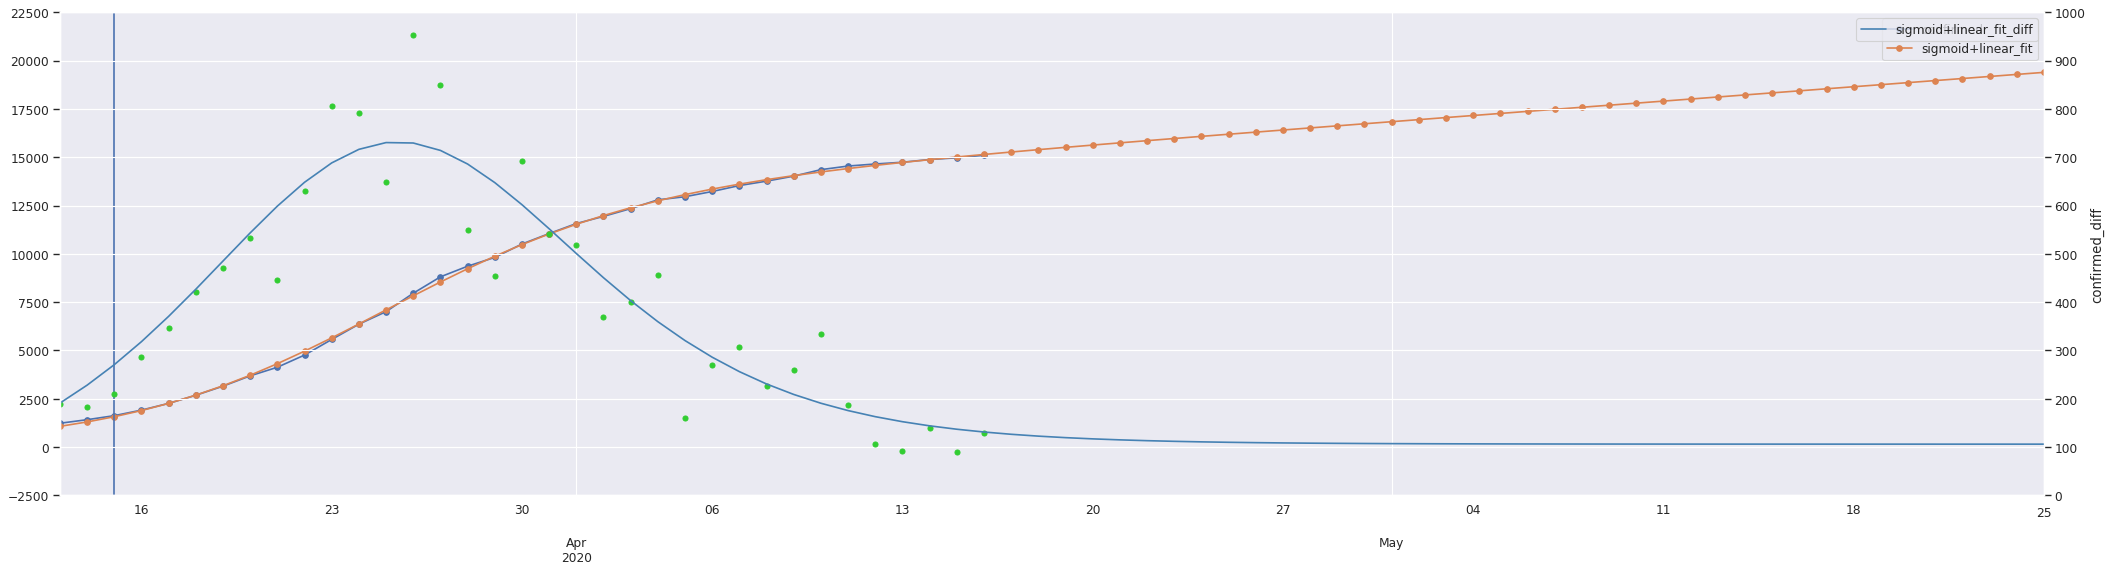

In [26]:
# country_name, first_date, init_add, restriction_start_date = 'Austria', pd.to_datetime('2020-02-19'), 600, datetime.datetime(2020, 3, 15)
country_name, first_date, init_add, restriction_start_date = 'Austria', pd.to_datetime('2020-03-12'), 600, datetime.datetime(2020, 3, 15)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')

l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(0.0, e2, l));

In [27]:
ldf[[label + '_fit_diff']].apply(['max'])

,sigmoid+linear_fit_diff
max,730.277094


In [28]:
lds = ldf['confirmed']
idx = lds.index.get_loc(lds.last_valid_index())
lds.iloc[idx] - lds.iloc[idx-1]

129.0

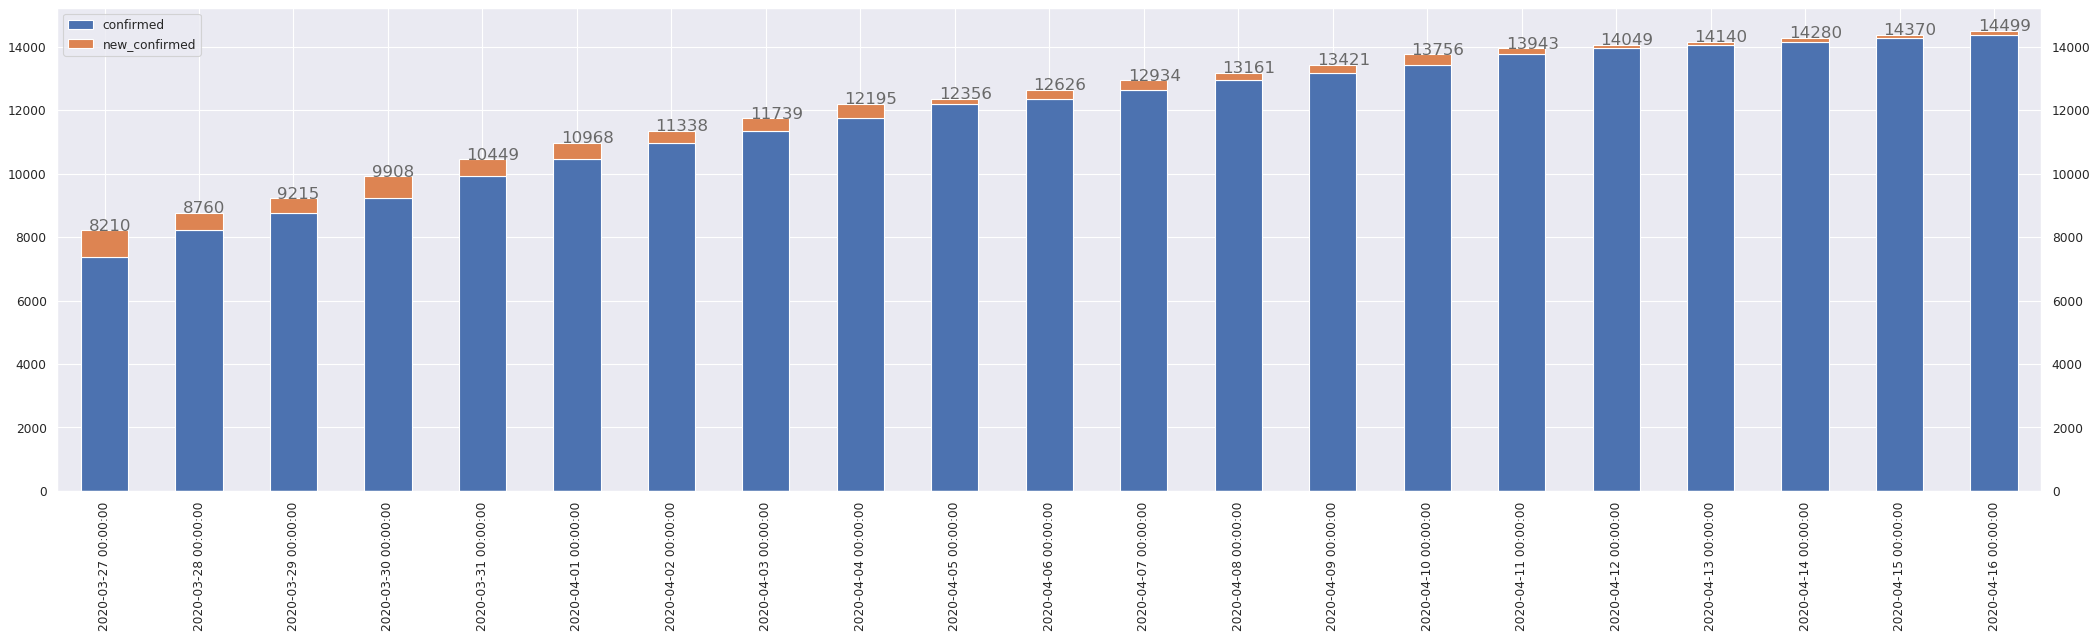

In [29]:
cbr_austria.plot_daily_stacked()

[COVID-19-Pandemie#Dänemark](https://de.wikipedia.org/wiki/COVID-19-Pandemie#D%C3%A4nemark)

> Dänemark hat besonders früh mit strikten Maßnahmen auf die Corona-Krise reagiert, unter anderem sind seit dem 14. März die Grenzen für Ausländer ohne triftigen Einreisegrund geschlossen.

`2020-03-14`

sigmoid 2020-04-27 00:00:00 [9432.70230556    0.11525987   -3.3122896 ] 0.02865270108037099 0.0


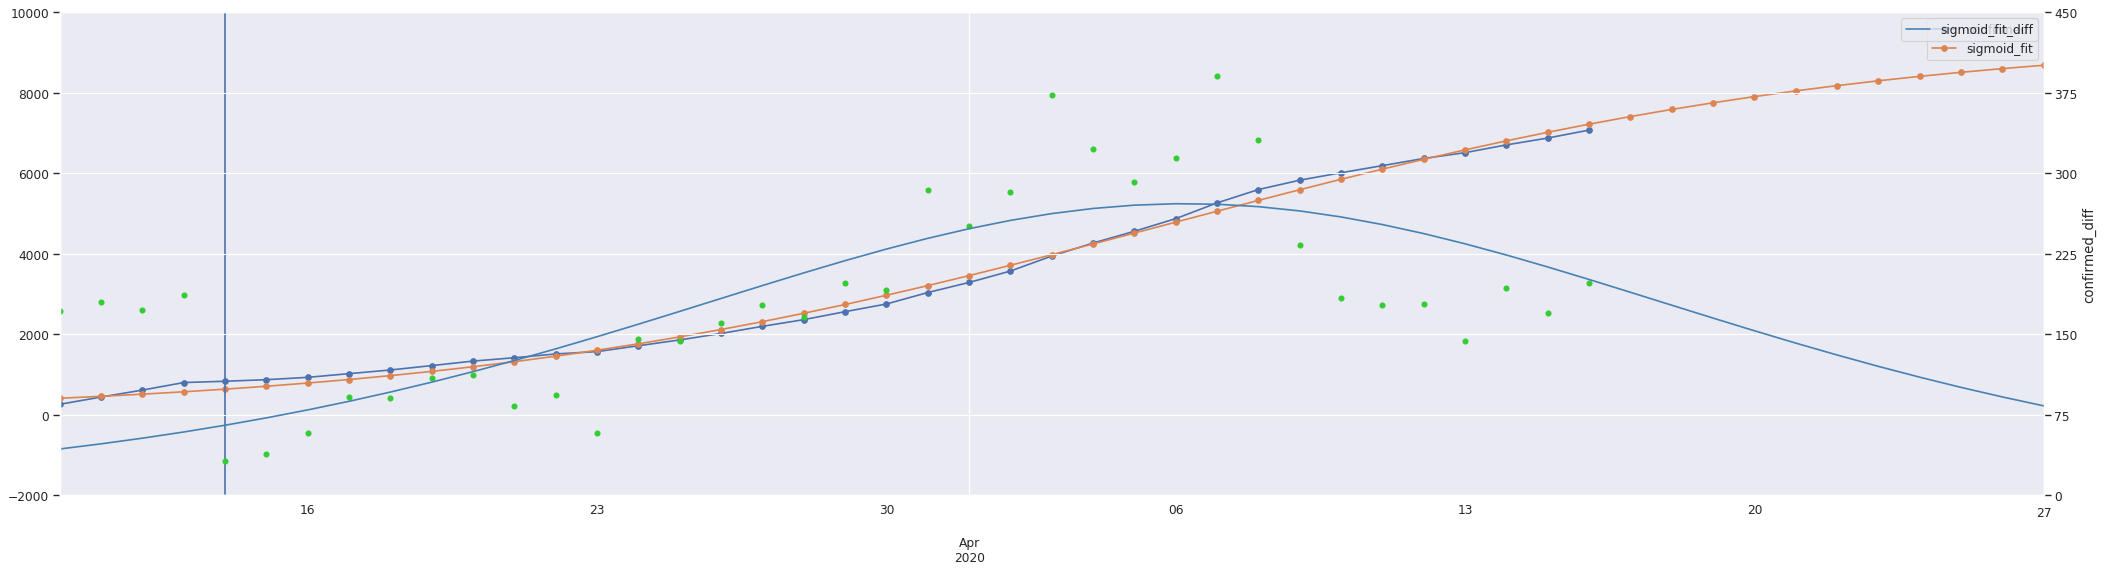

In [30]:
country_name, first_date, init_add, restriction_start_date = 'Denmark', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 14)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')

l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(0.0, e2, l));

In [31]:
ldf[[label + '_fit_diff']].apply(['max'])

,sigmoid_fit_diff
max,271.676928


There are several data issues since 2020-03-12/2020-03-13 in the input data as pointed out here: [Italy has the same number of cases today as they did yesterday.](https://github.com/CSSEGISandData/COVID-19/issues/599)

Also trying to get the raw numbers that [Coronavirus-Monitor](https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/?fbclid=IwAR04HlqzakGaNssQzbz4d8o8R3gz0C910U8tvfYlBT6P0lVJJvHfk9uS2rc) is using for Germany from [@datentaeterin](https://twitter.com/datentaeterin/status/1237807179815686144). These numbers seem to be more up-to-date than all the other data-sources.

In [32]:
fname = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
alternative_italy_data = pd.read_csv(fname)
dates = pd.to_datetime(alternative_italy_data['data']).dt.date
alternative_italy_data = alternative_italy_data.rename(columns={"totale_casi": "confirmed", "deceduti": "death", "dimessi_guariti": "recovered"})
alternative_italy_data = alternative_italy_data[['confirmed', 'recovered', 'death']].copy()
for property in ['confirmed', 'recovered', 'death']:
    diff = alternative_italy_data[property].values[1:] - alternative_italy_data[property].values[:-1]
    alternative_italy_data['new_' + property] = np.concatenate([np.array([0]), diff])  
alternative_italy_data.index = dates
alternative_italy_data.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-04-12,156363,34211,19899,4092,1677,431
2020-04-13,159516,35435,20465,3153,1224,566
2020-04-14,162488,37130,21067,2972,1695,602
2020-04-15,165155,38092,21645,2667,962,578
2020-04-16,168941,40164,22170,3786,2072,525


In [33]:
cbr_italy = covid19.CasesByRegion('Italy', df=alternative_italy_data)
cbr_italy.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-04-12,156363,34211,19899,4092,1677,431
2020-04-13,159516,35435,20465,3153,1224,566
2020-04-14,162488,37130,21067,2972,1695,602
2020-04-15,165155,38092,21645,2667,962,578
2020-04-16,168941,40164,22170,3786,2072,525


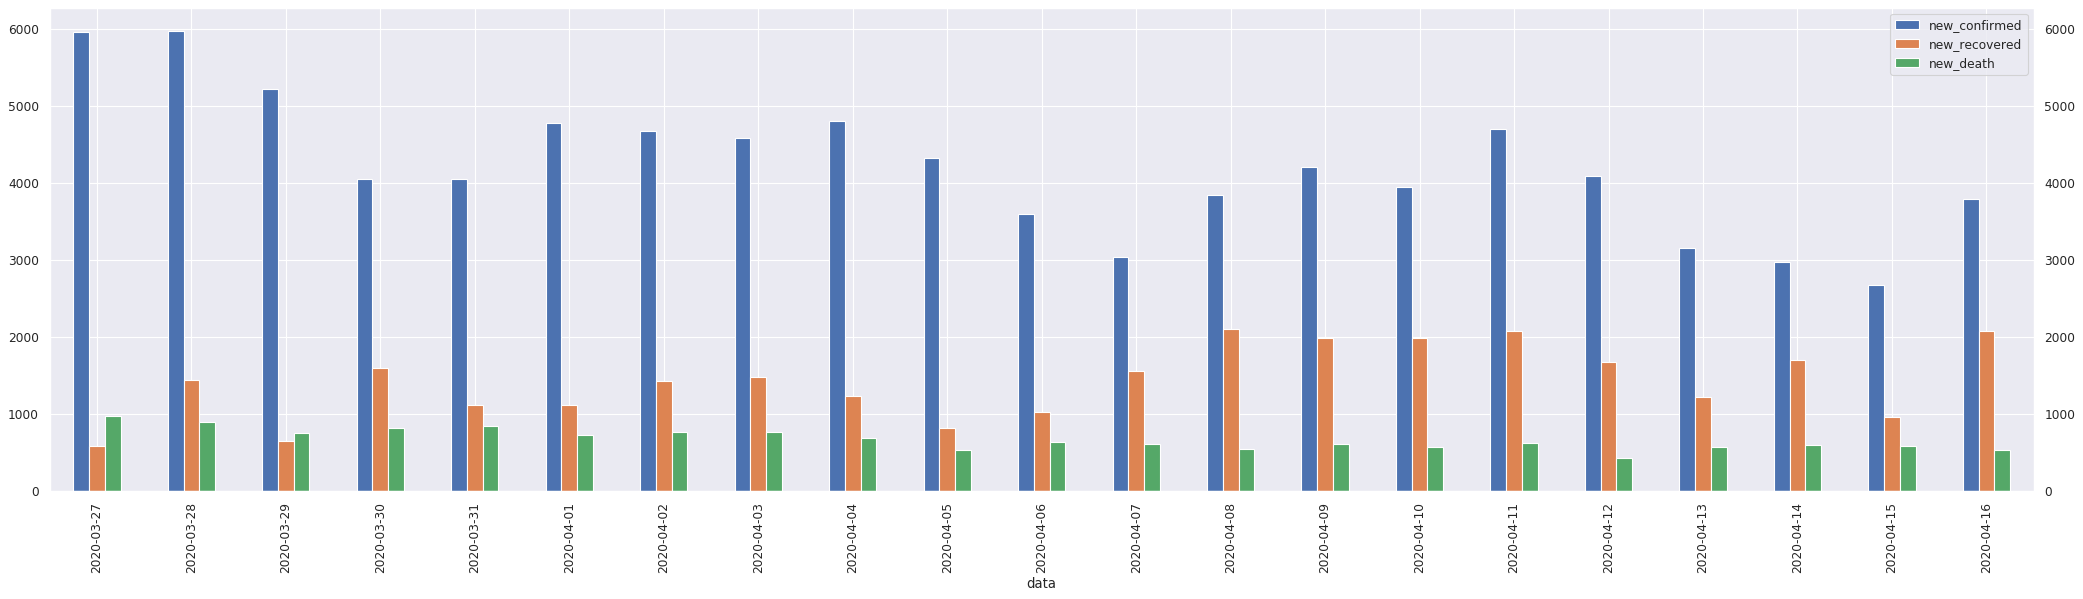

In [34]:
cbr_italy.plot_daily_stats()

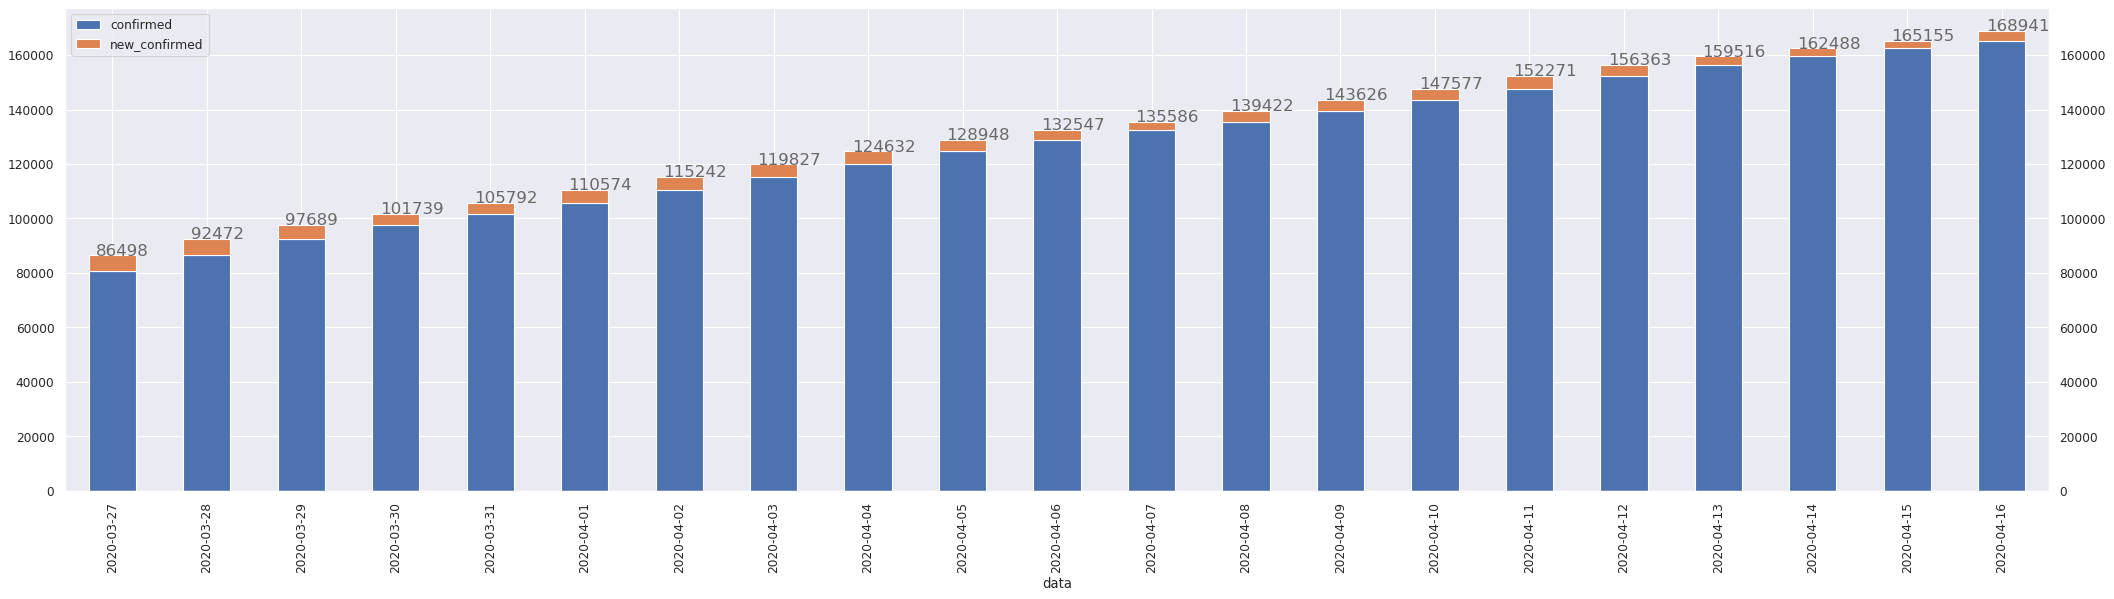

In [35]:
cbr_italy.plot_daily_stacked()

In [36]:
cbr_spain = covid19.CasesByRegion('Spain')
cbr_spain.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-12,166831,62391,17209,3804,3282,603
2020-04-13,170099,64727,17756,3268,2336,547
2020-04-14,172541,67504,18056,2442,2777,300
2020-04-15,177644,70853,18708,5103,3349,652
2020-04-16,184948,74797,19315,7304,3944,607


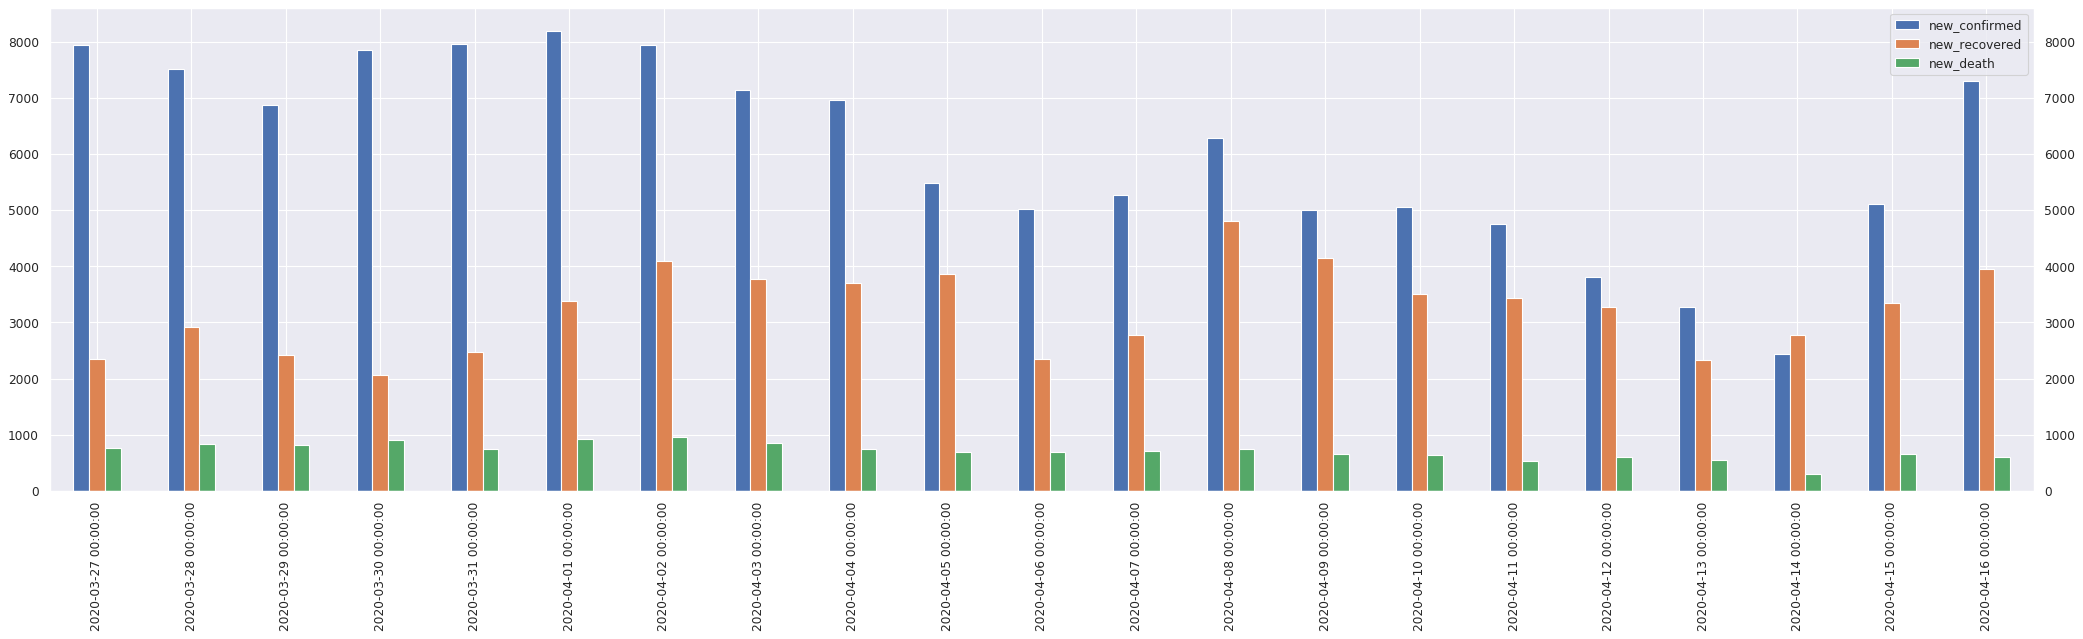

In [37]:
cbr_spain.plot_daily_stats()

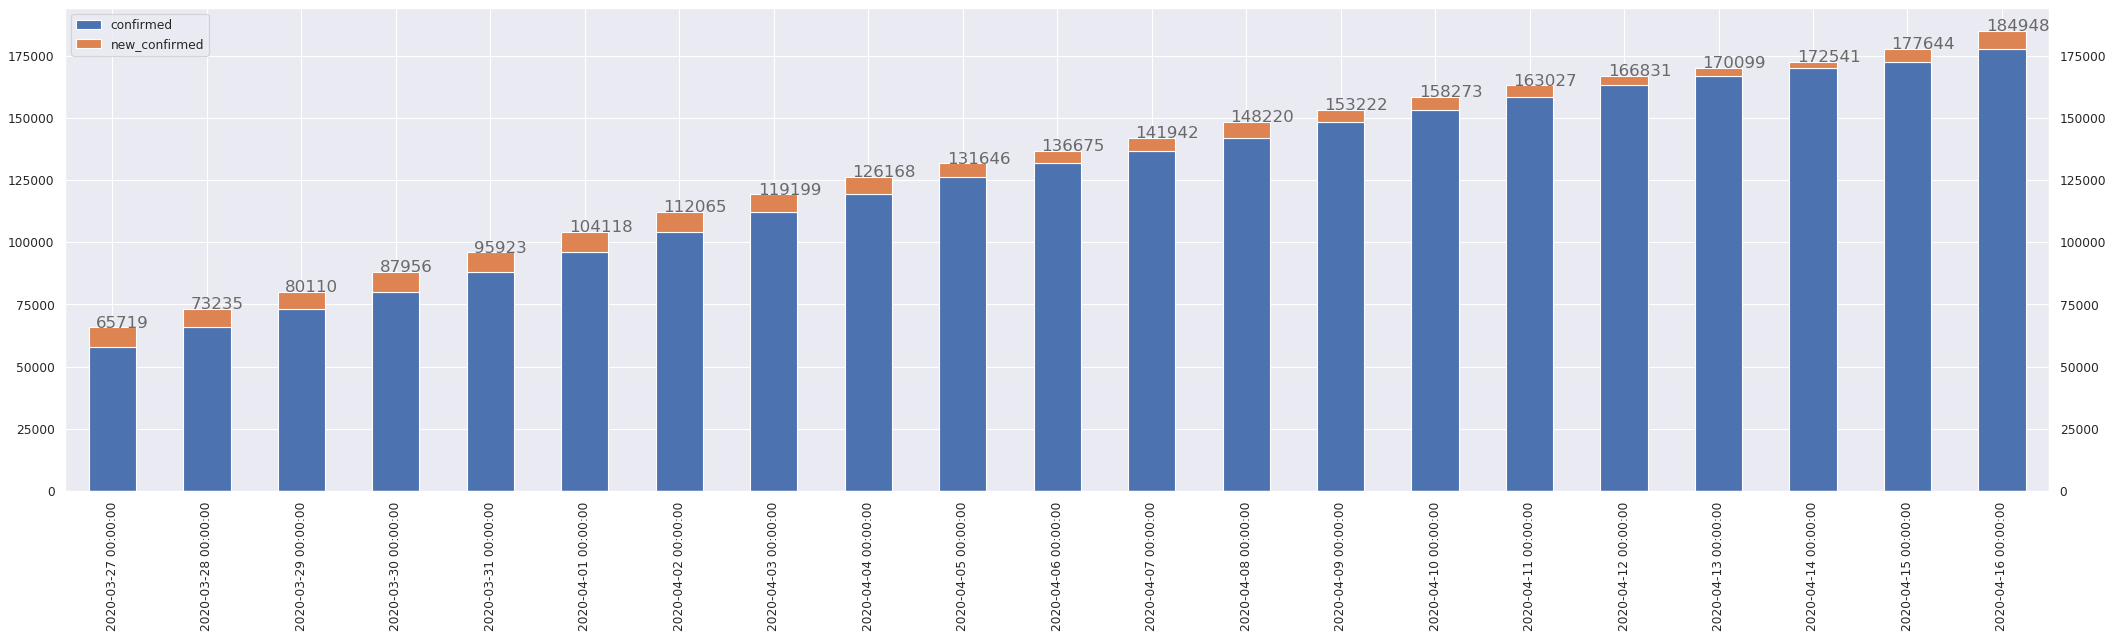

In [38]:
cbr_spain.plot_daily_stacked()

* [Community Wiki: Resources on Data Science (and friends) vs. COVID-19](https://discourse.data-against-covid.org/t/community-wiki-resources-on-data-science-and-friends-vs-covid-19/731)
* [Number of deaths per age group per country?](https://discourse.data-against-covid.org/t/number-of-deaths-per-age-group-per-country/940)



* [opencovid19-fr / data](https://github.com/opencovid19-fr/data/blob/master/README.en.md)
    * [chiffres-cles.csv](https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv)
    * [dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/5e09dff7cb434fb194e22261689e2887)
    * [santepubliquefrance](https://www.santepubliquefrance.fr/maladies-et-traumatismes/maladies-et-infections-respiratoires/infection-a-coronavirus/articles/infection-au-nouveau-coronavirus-sars-cov-2-covid-19-france-et-monde)

In [39]:
fname = 'https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv'
alternative_france_data = pd.read_csv(fname)
alternative_france_data = alternative_france_data[(alternative_france_data['granularite'] == 'pays') & (alternative_france_data['source_type'] == 'ministere-sante')]
dates = pd.to_datetime(alternative_france_data['date']).dt.date
alternative_france_data = alternative_france_data.rename(columns={"cas_confirmes": "confirmed", "deces": "death", "gueris": "recovered"})
alternative_france_data['death'] += alternative_france_data['deces_ehpad']
alternative_france_data = alternative_france_data[['confirmed', 'recovered', 'death']].copy()
for property in ['confirmed', 'recovered', 'death']:
    diff = alternative_france_data[property].values[1:] - alternative_france_data[property].values[:-1]
    alternative_france_data['new_' + property] = np.concatenate([np.array([0]), diff])  
alternative_france_data.index = dates
alternative_france_data.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
date,,,,,,
2020-04-12,95403.0,27186.0,14393.0,1613.0,795.0,561.0
2020-04-13,98076.0,27718.0,14967.0,2673.0,532.0,574.0
2020-04-14,103573.0,28805.0,15729.0,5497.0,1087.0,762.0
2020-04-15,106206.0,30995.0,17167.0,2633.0,2190.0,1438.0
2020-04-16,108847.0,32812.0,17920.0,2641.0,1817.0,753.0


In [40]:
cbr_france = covid19.CasesByRegion('France', df=alternative_france_data)
cbr_france.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
date,,,,,,
2020-04-12,95403.0,27186.0,14393.0,1613.0,795.0,561.0
2020-04-13,98076.0,27718.0,14967.0,2673.0,532.0,574.0
2020-04-14,103573.0,28805.0,15729.0,5497.0,1087.0,762.0
2020-04-15,106206.0,30995.0,17167.0,2633.0,2190.0,1438.0
2020-04-16,108847.0,32812.0,17920.0,2641.0,1817.0,753.0


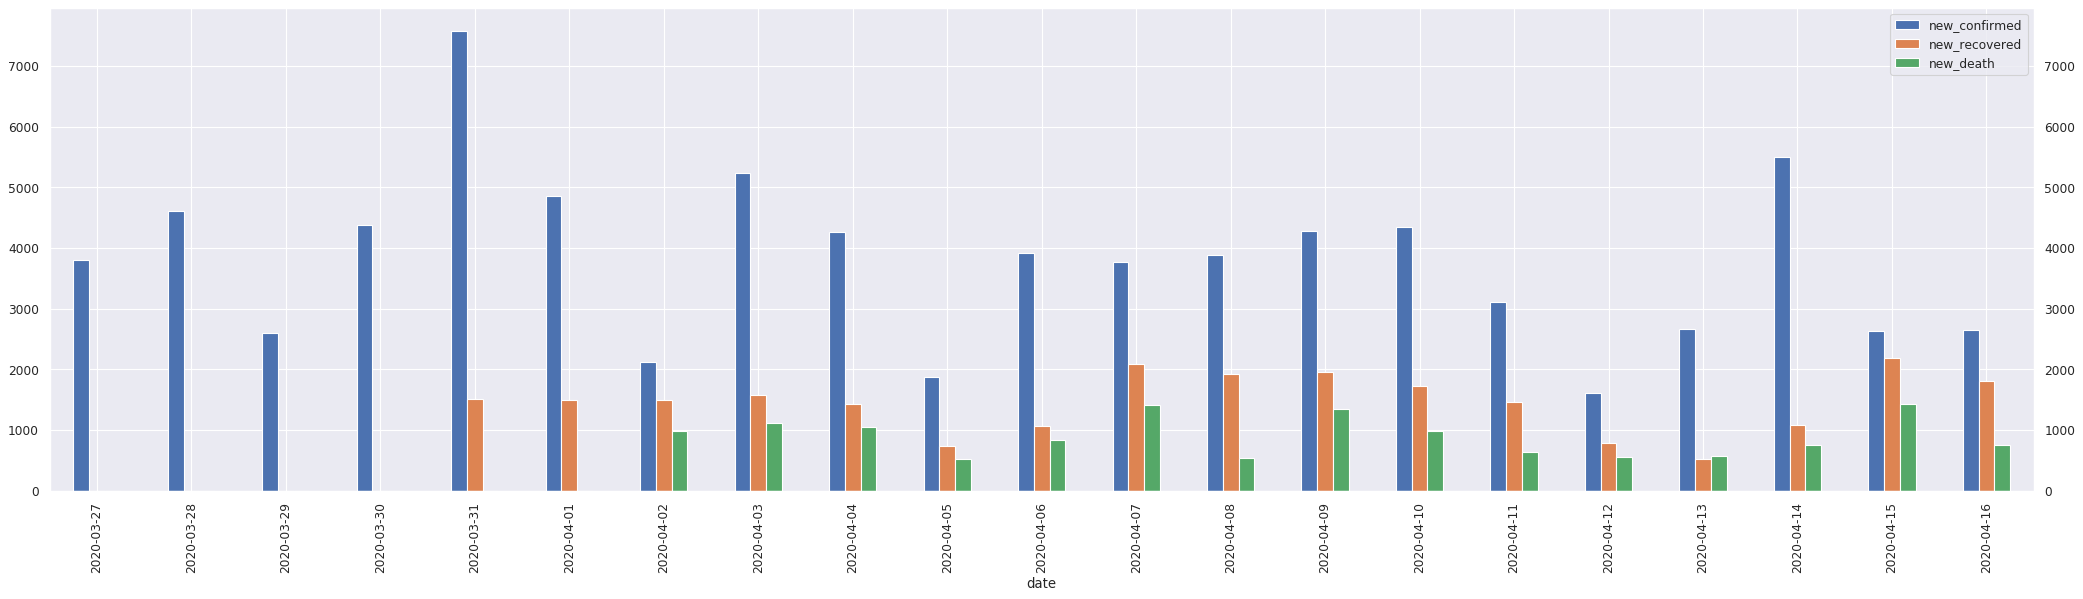

In [41]:
cbr_france.plot_daily_stats()

In [42]:
# cbr_france.df.to_excel('2020-04-17-france.xlsx')

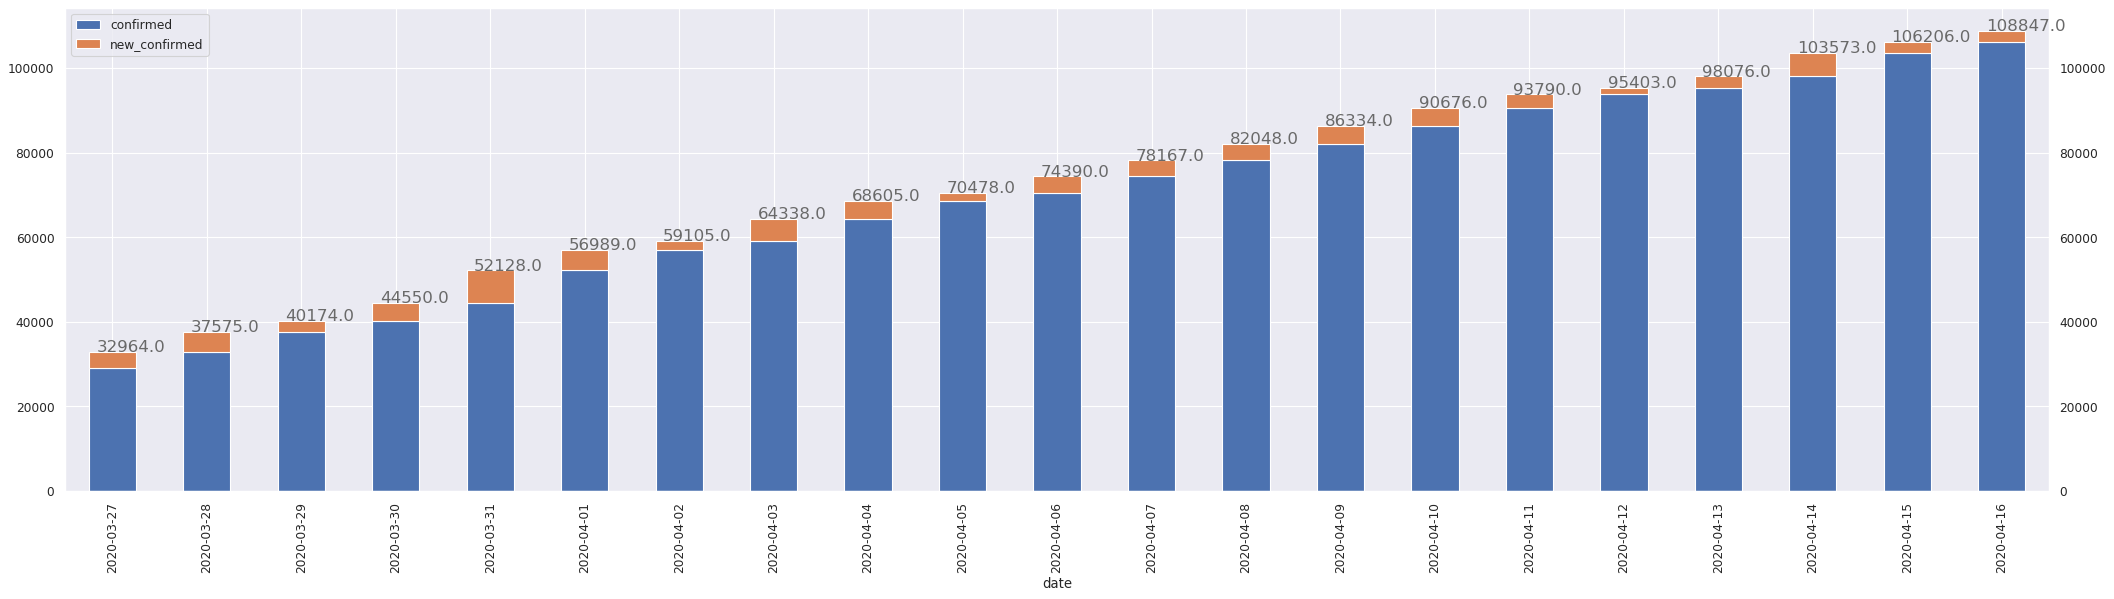

In [43]:
cbr_france.plot_daily_stacked()

In [44]:
cbr_south_korea = covid19.CasesByRegion('Korea, South')
cbr_south_korea.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-12,10512,7368,214,32,125,3
2020-04-13,10537,7447,217,25,79,3
2020-04-14,10564,7534,222,27,87,5
2020-04-15,10591,7616,225,27,82,3
2020-04-16,10613,7757,229,22,141,4


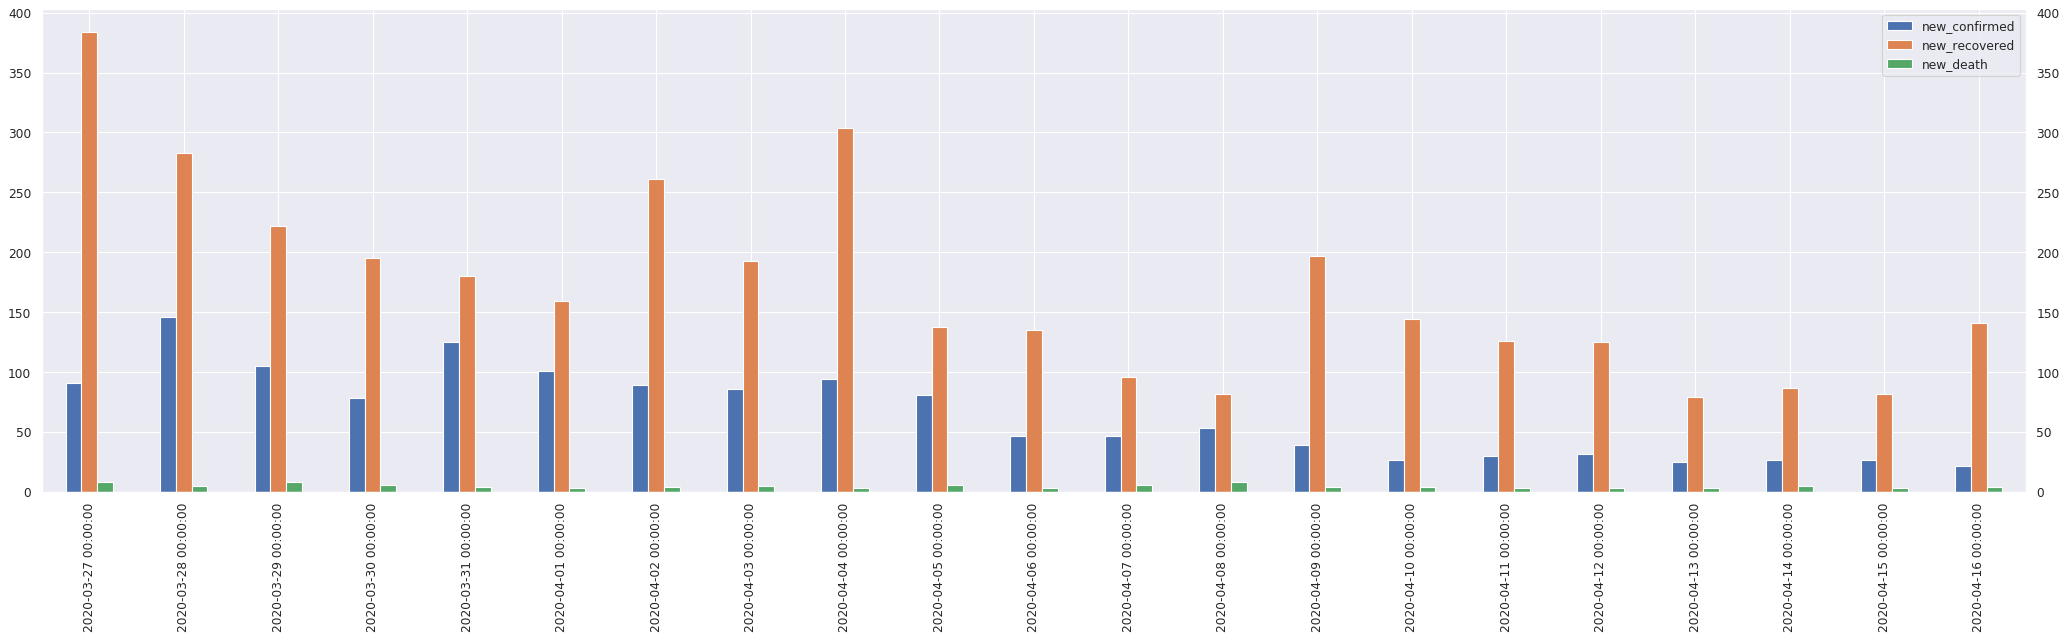

In [45]:
cbr_south_korea.plot_daily_stats()

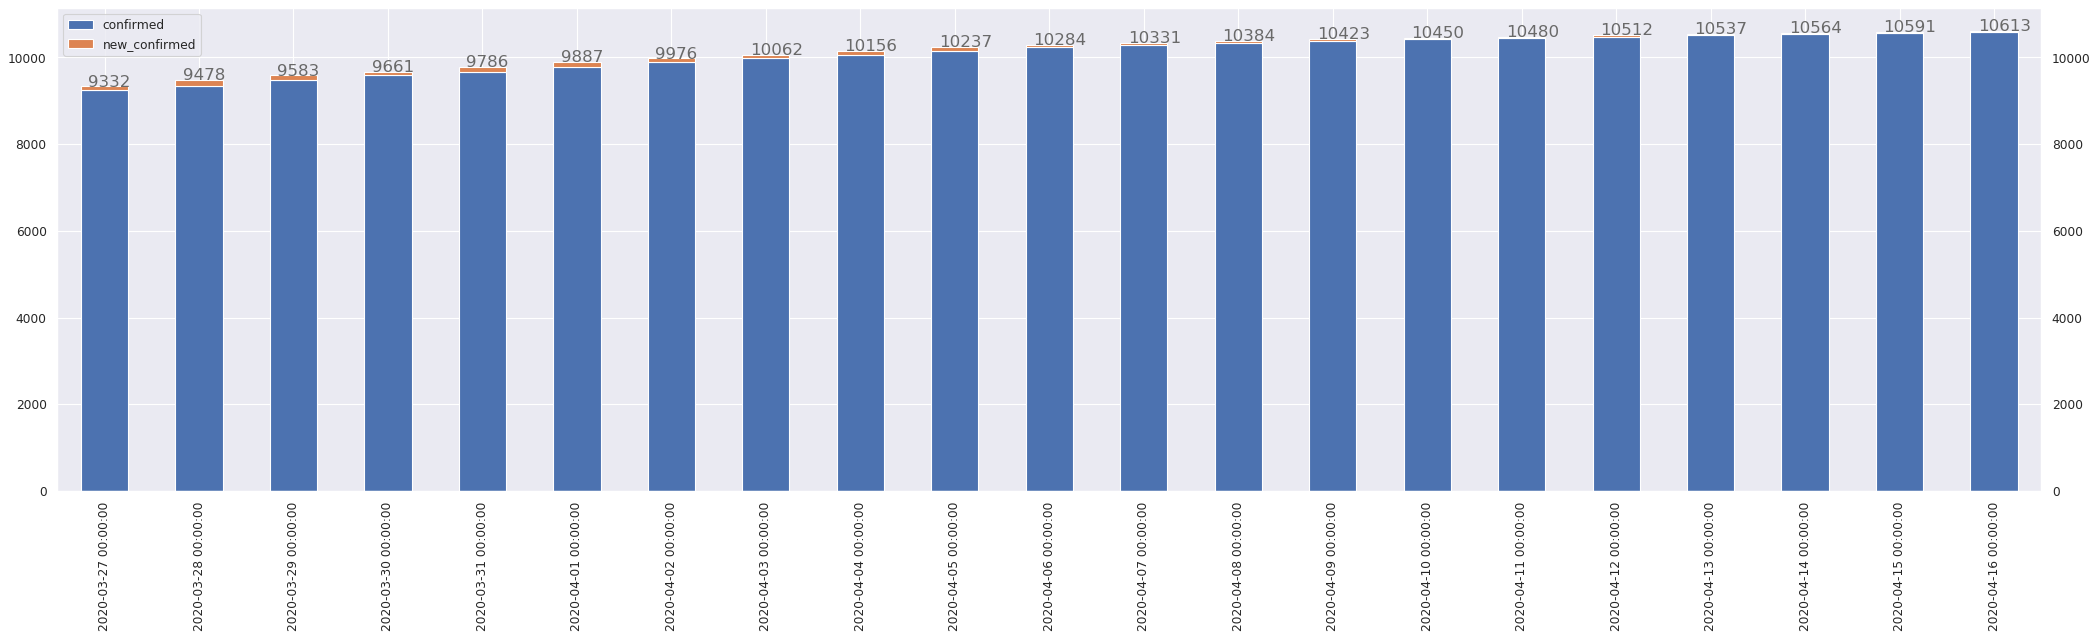

In [46]:
cbr_south_korea.plot_daily_stacked()

In [47]:
cbr_uk = covid19.CasesByRegion('United Kingdom')
cbr_uk.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-12,85206,626,10629,5332,4,737
2020-04-13,89570,304,11347,4364,-322,718
2020-04-14,94845,323,12129,5275,19,782
2020-04-15,99483,368,12894,4638,45,765
2020-04-16,104145,375,13759,4662,7,865


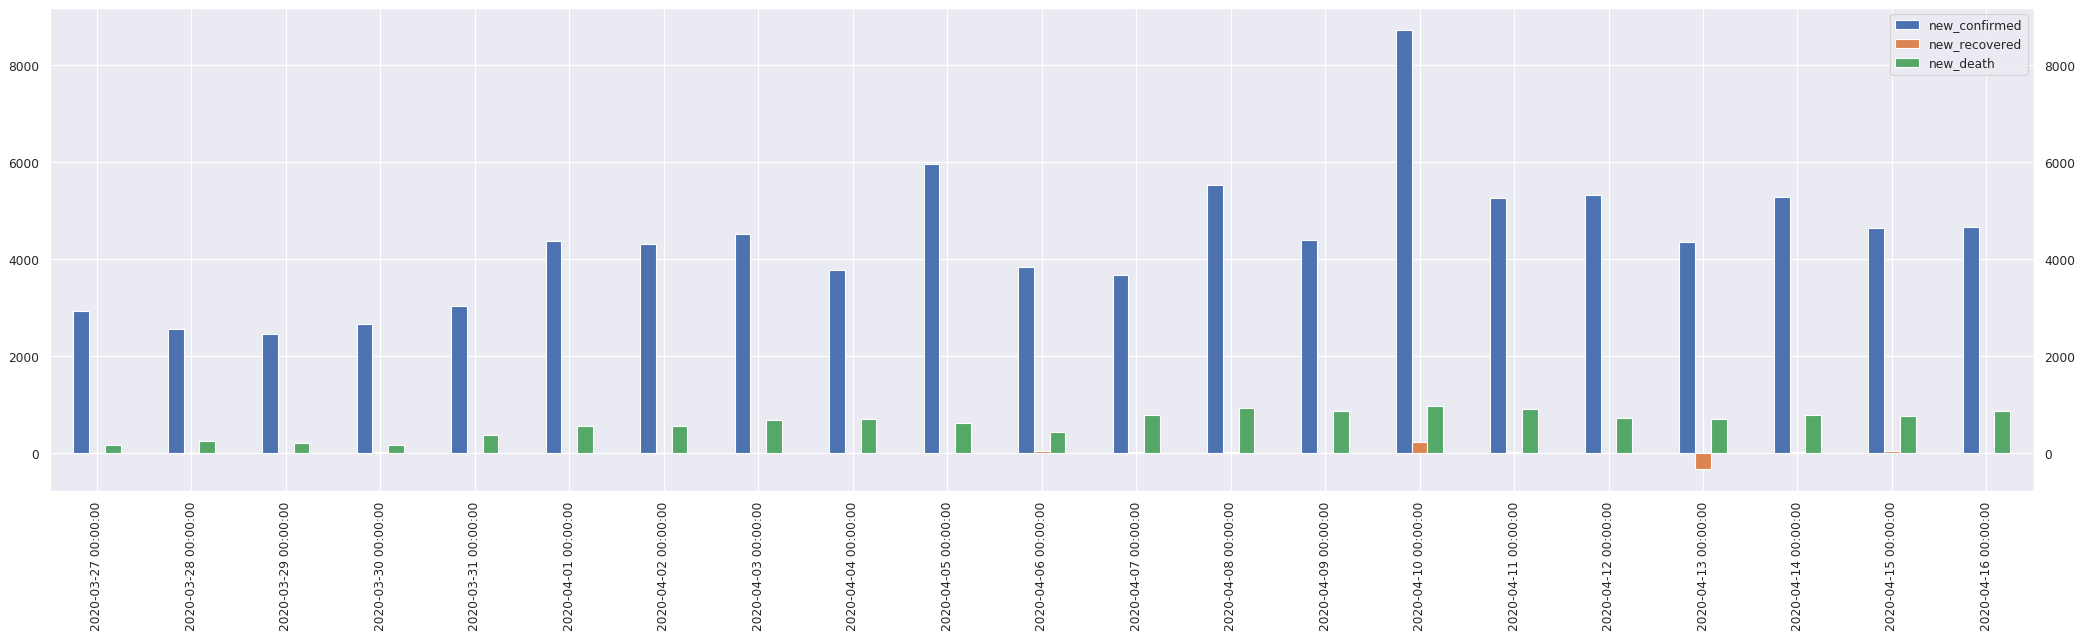

In [48]:
cbr_uk.plot_daily_stats()

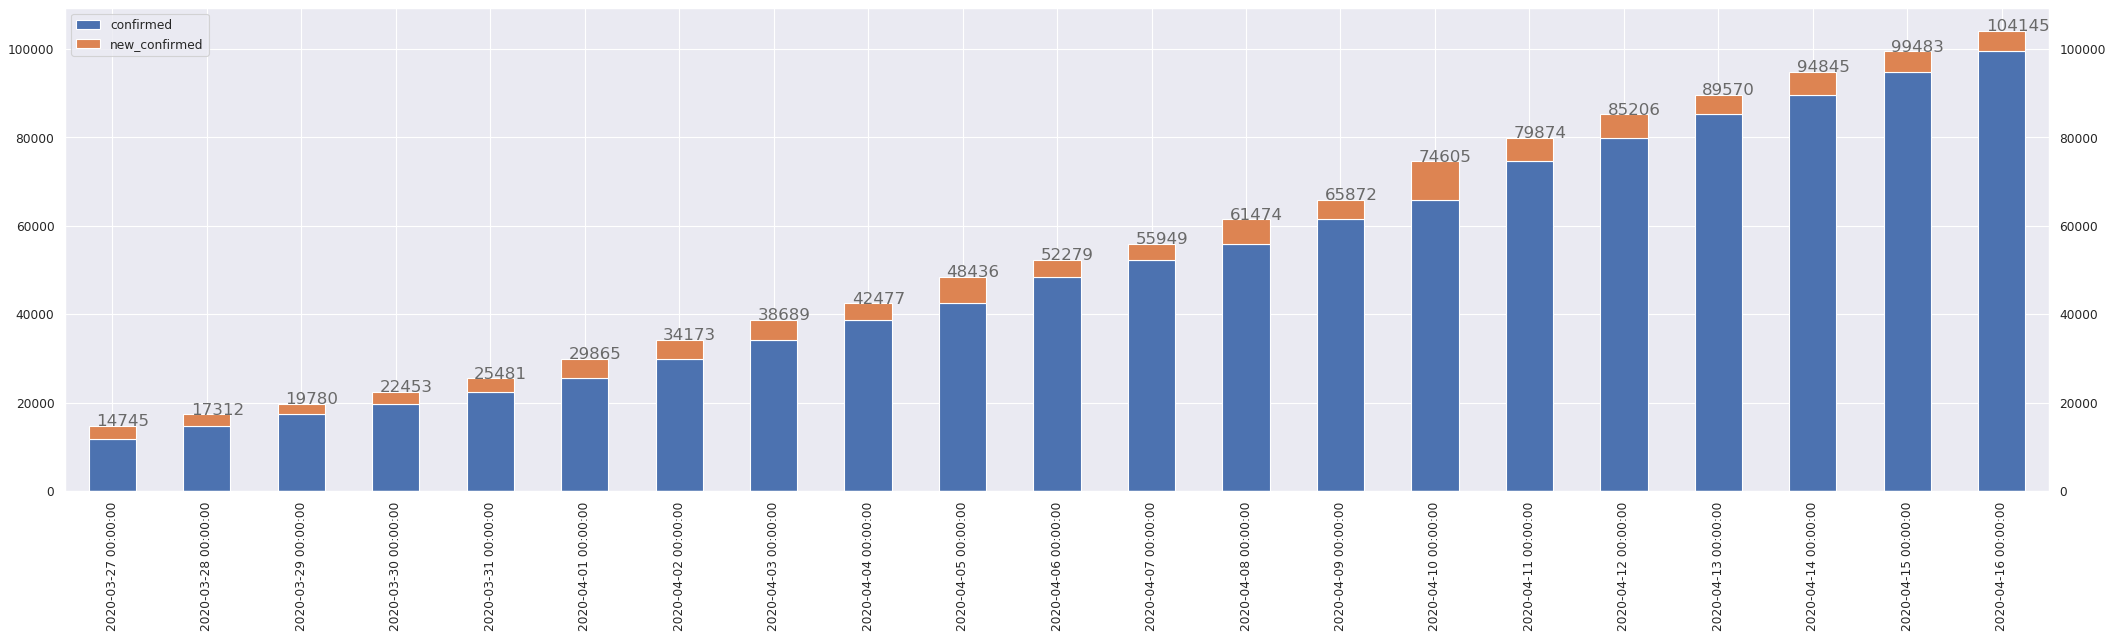

In [49]:
cbr_uk.plot_daily_stacked()

In [50]:
cbr_us = covid19.CasesByRegion('US')
cbr_us.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-12,555313,32988,22019,28917,1718,1557
2020-04-13,580619,43482,23528,25306,10494,1509
2020-04-14,607670,47763,25831,27051,4281,2303
2020-04-15,636350,52096,28325,28680,4333,2494
2020-04-16,667801,54703,32916,31451,2607,4591


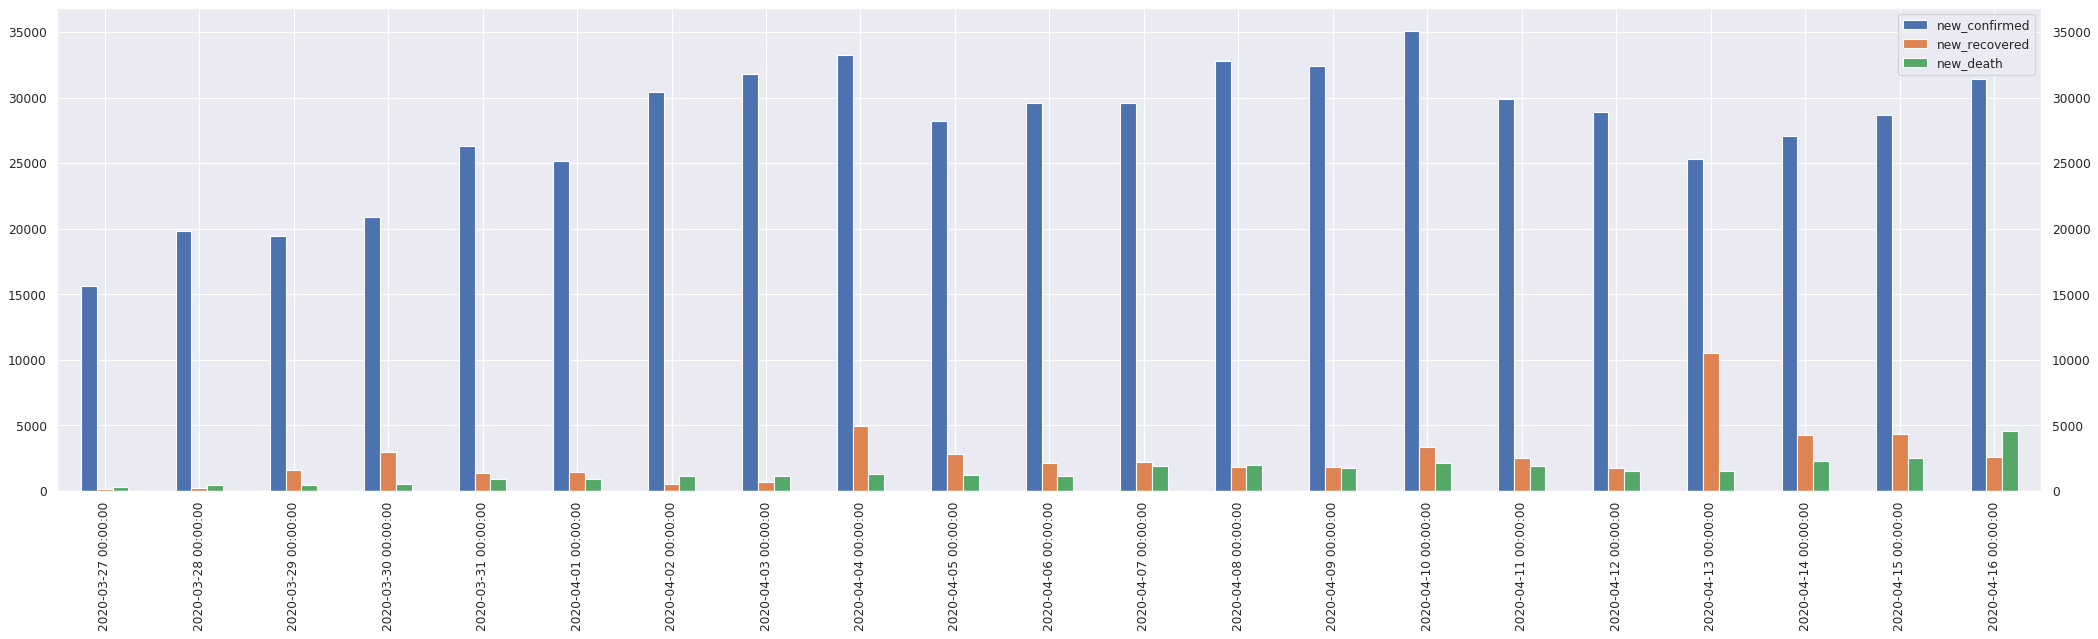

In [51]:
cbr_us.plot_daily_stats()

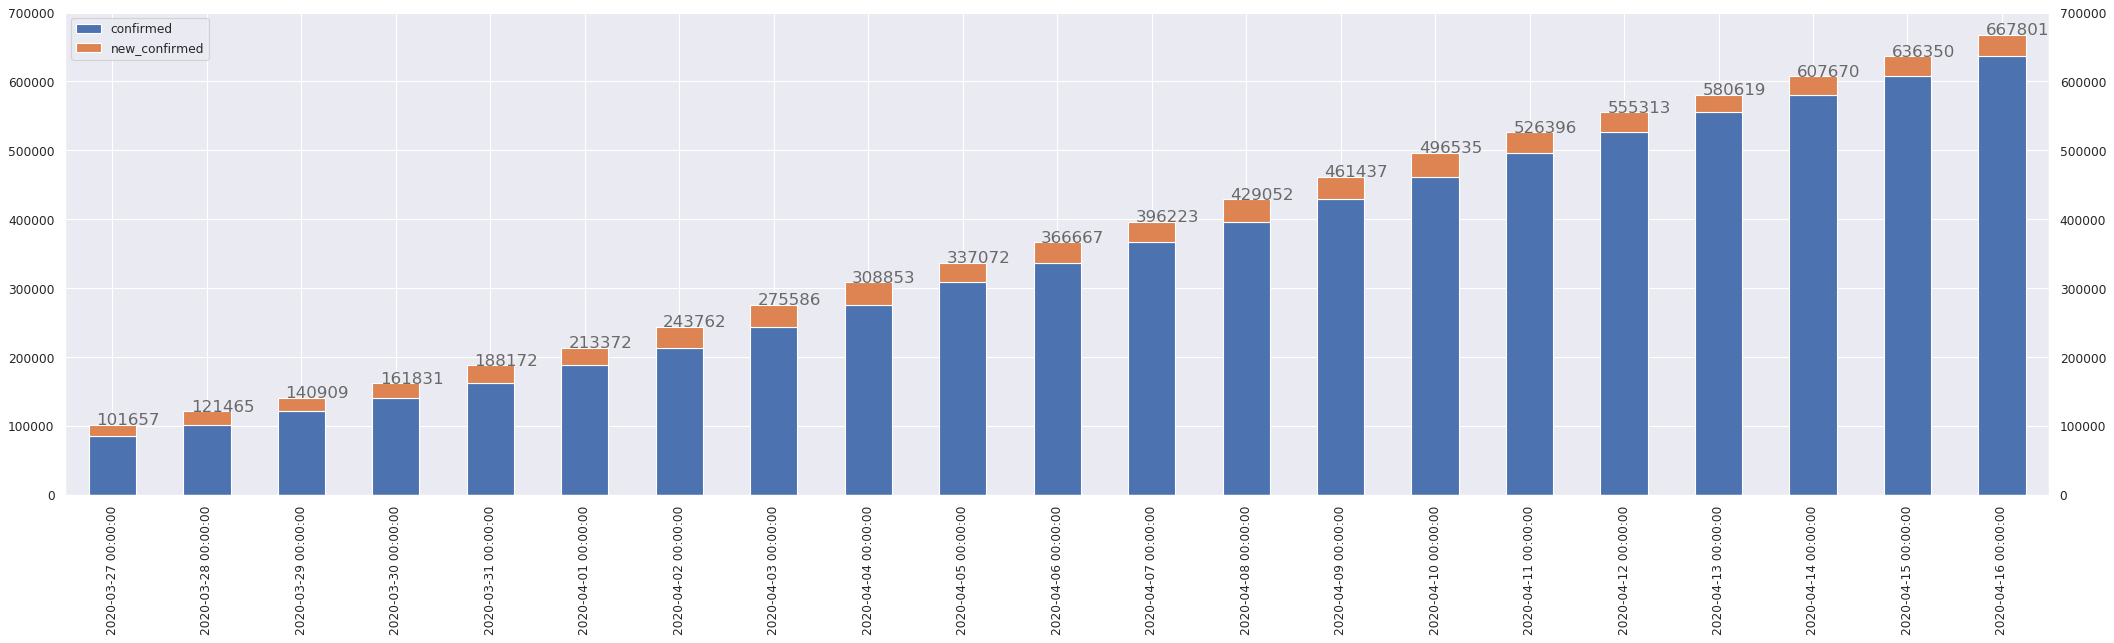

In [52]:
cbr_us.plot_daily_stacked()

In [53]:
cbr_switzerland = covid19.CasesByRegion('Switzerland')
cbr_switzerland.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-12,25415,12700,1106,308,600,70
2020-04-13,25688,13700,1138,273,1000,32
2020-04-14,25936,13700,1174,248,0,36
2020-04-15,26336,15400,1239,400,1700,65
2020-04-16,26732,15900,1281,396,500,42


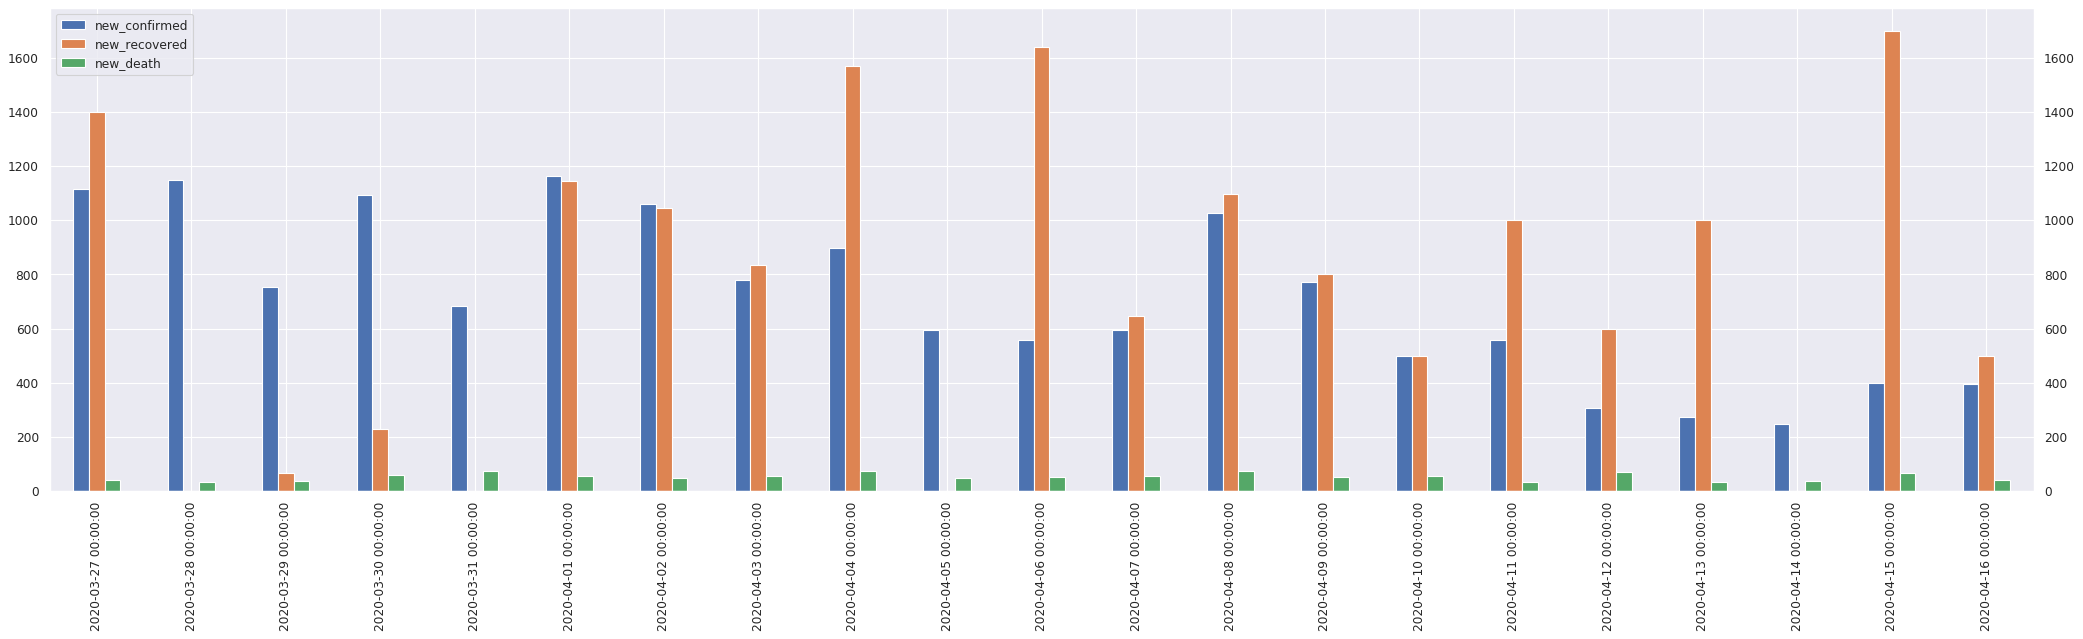

In [54]:
cbr_switzerland.plot_daily_stats()

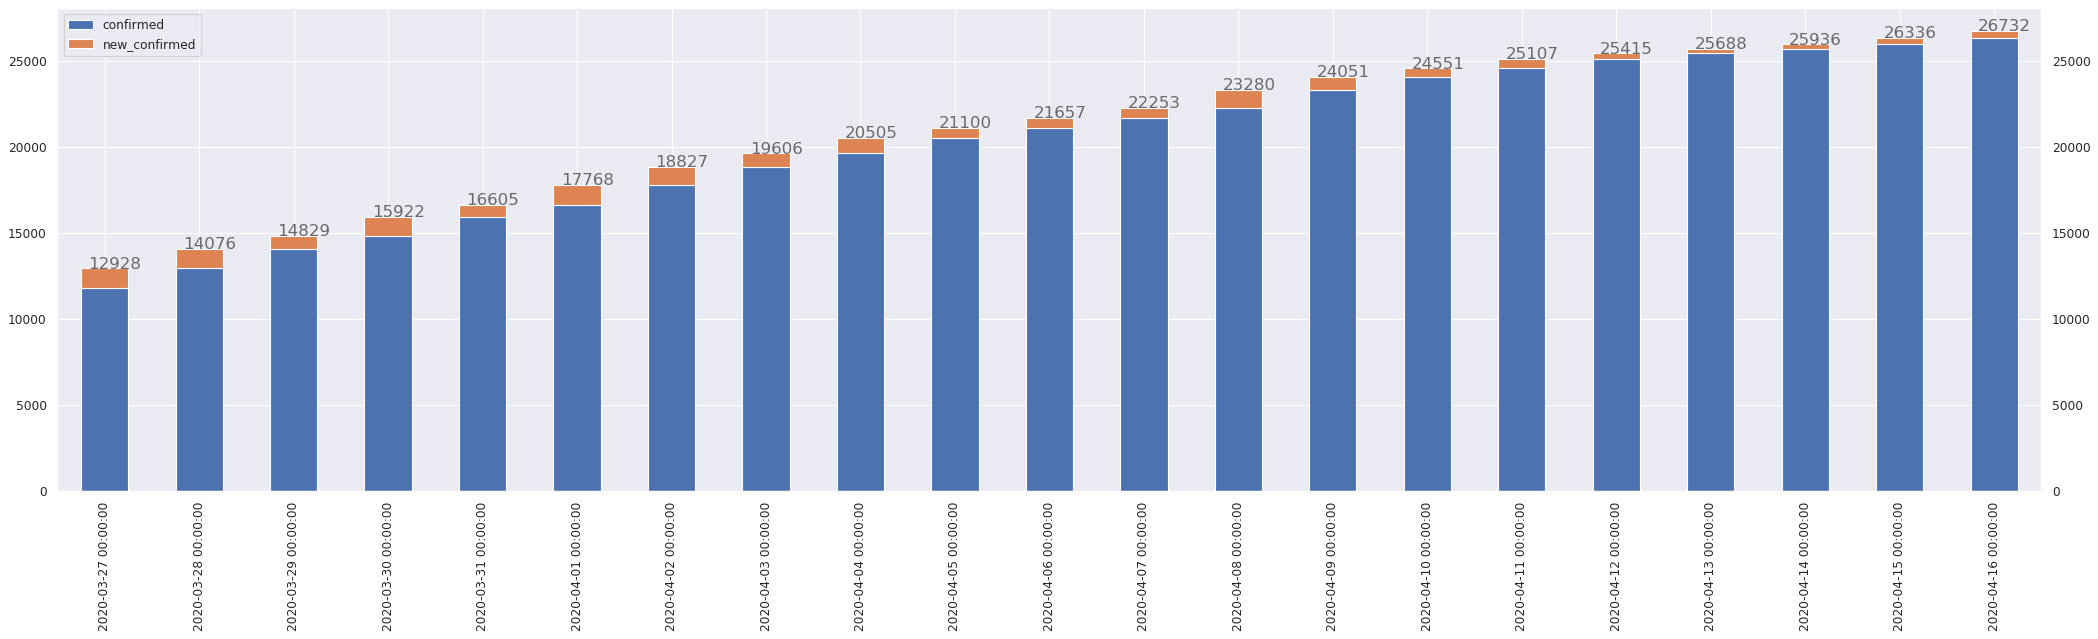

In [55]:
cbr_switzerland.plot_daily_stacked()

In [56]:
df_co = covid19.get_country_overview()
df_co.head()

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-04-16,,,,,
MS Zaandam,9,0,2,22.222222,66.666667
Burundi,5,0,1,20.000000,50.000000
Sudan,32,4,5,15.625000,50.000000
Algeria,2268,783,348,15.343915,30.742049
Bahamas,53,6,8,15.094340,53.333333


In [57]:
df_co[df_co.confirmed > 2000].round(1)

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-04-16,,,,,
Algeria,2268,783,348,15.3,30.7
Belgium,34809,7562,4857,14.0,39.1
United Kingdom,104145,375,13759,13.2,97.3
Italy,168941,40164,22170,13.1,35.6
France,147091,33327,17941,12.2,35.0
Netherlands,29383,311,3327,11.3,91.4
Sweden,12540,550,1333,10.6,70.8
Spain,184948,74797,19315,10.4,20.5
Indonesia,5516,548,496,9.0,47.5
